**Trabajo de Fin de Grado**  
- Autor: Pablo González Martín  
- Director: Carlos Javier Pérez González

Grado en Matemáticas  
Universidad de La Laguna  
2024/25

Este notebook forma parte del Trabajo de Fin de Grado titulado *“Fundamentos de las redes neuronales
convolucionales y su aplicación en la
detección de enfermedades oculares”*, cuyo objetivo es desarrollar un modelo de clasificación de enfermedades oculares a partir de imágenes médicas.


Se recomienda descargar el notebook y el dataset por separado.

- Descargar el dataset en MiUnidad del Drive.
- Ejecutar el notebook empleando GPU a través de google colab (arriva a la izquierda seleccionar 'Change runtime type' a una opción que emplee GPU).
- En mi caso, contraté Google Colab Pro que ofrece mayor cantidad de computación y memoria para poder ejecutar este tipo de redes. En caso de no ser contratado será necesario con mucha probabilidad reducir características como el número de parámetros de la red, el tamaño del lote, el tamaño de las imágenes ...

# Clasificador de enfermedades oculares

El siguiente conjunto de datos trata sobre 4 tipos de enfermedades oculares, y estamos intentando construir un modelo que pueda reconocer el tipo de enfermedad en una clasificación de 4 clases, basándose en las imágenes disponibles de los ojos.

Las cuatro categorías incluyen: <br>
1. Cataract <br>
2. Diabetic Retinopathy <br>
3. Glaucoma <br>
4. Normal

Data link:<br>
https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

In [1]:
import os
import glob
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split      # dividing the dataset
from sklearn.preprocessing import LabelEncoder            # for converting str labels to number
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sn
import random


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
import pathlib

import warnings
warnings.filterwarnings("ignore")

Importar funciones

In [2]:
from utils import *

Comprobar el uso de GPU (acelerará considerablemente el entrenamiento)

https://www.youtube.com/watch?v=hu1GJ2p9mxI

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
sys.version

Num GPUs Available:  1
2.18.0


'3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]'

**IMPORTANTE** En caso de no tener GPU habilitada no ejecutar las celdas de las secciones de *Creando el modelo*, *Entrenando el modelo* y *Hyperparameter tuning* sino descargar el modelo preentrenado en la seccion *Resultados del entrenamiento*.

## Google Colab + Drive (recomendado)

**CASO USANDO DRIVE Y GOOGLE COLAB**. Incluir la carpeta con nombre dataset en MiUnidad en el Drive (en caso de tener los datos en local, declarar path como la ruta a la carpeta dataset). Ejecutar el notebook y subir en el directorio del notebook utils.py.

In [4]:
path = os.path.join(os.getcwd(),'drive','MyDrive', 'dataset_enfermedades_oculares')

Montar Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset en local en esta carpeta

In [ ]:
path=os.path.join(os.getcwd(),'dataset_enfermedades_oculares')

# Análisis exploratorio de las imágenes

Imágenes por clase, dimensiones y formato

In [6]:
dataset_analysis(path)

--------------------------------------------------------------------------------
Subfolder 'normal' contains (1074 files):
- 1074 images of format JPEG:
  - 1074 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'glaucoma' contains (1007 files):
- 906 images of format JPEG:
  - 306 images with dimensions (512, 512), bit depth 24, mode RGB
  - 600 images with dimensions (256, 256), bit depth 24, mode RGB
- 101 images of format PNG:
  - 74 images with dimensions (2592, 1728), bit depth 24, mode RGB
  - 5 images with dimensions (1848, 1224), bit depth 24, mode RGB
  - 22 images with dimensions (2464, 1632), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'diabetic_retinopathy' contains (1098 files):
- 1098 images of format JPEG:
  - 1098 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------

Número de imágenes por clase

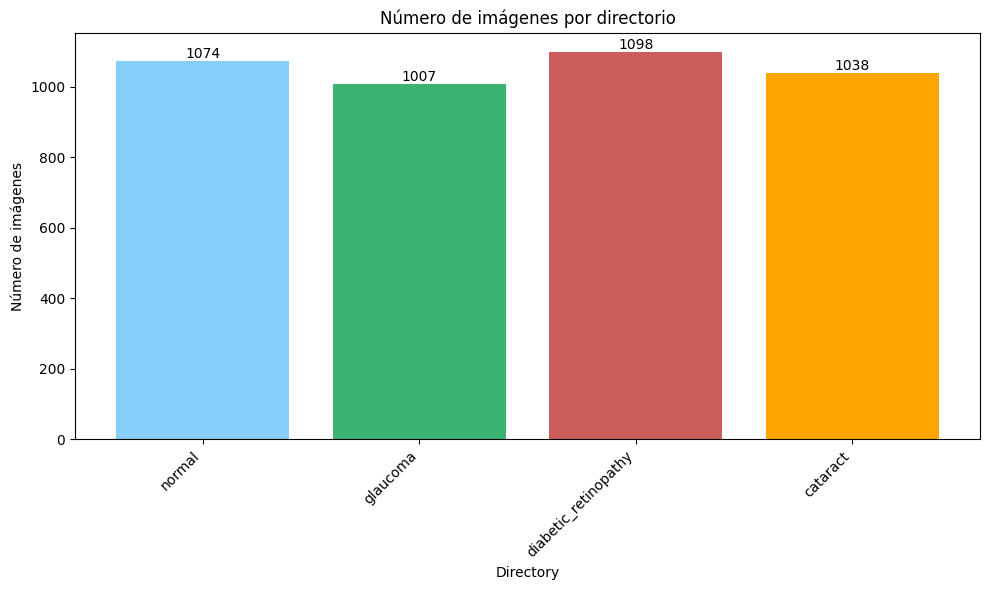

(['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract'],
 [1074, 1007, 1098, 1038])

In [7]:
plot_directory_image_counts(path, colors=['lightskyblue', 'mediumseagreen', 'indianred', 'orange'])

Análisis de las dimensiones de las imágenes

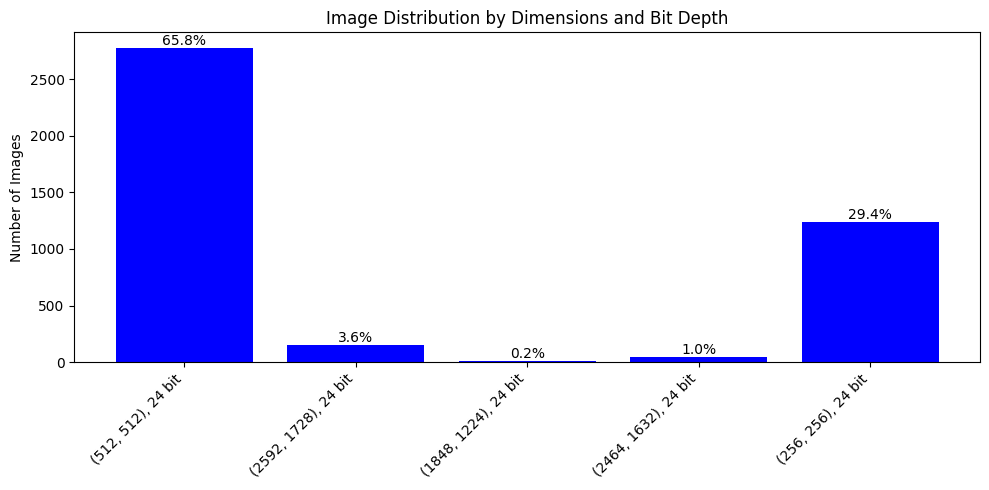

In [8]:
dataset_size_analysis(path)

Análisis de las dimensiones por clases

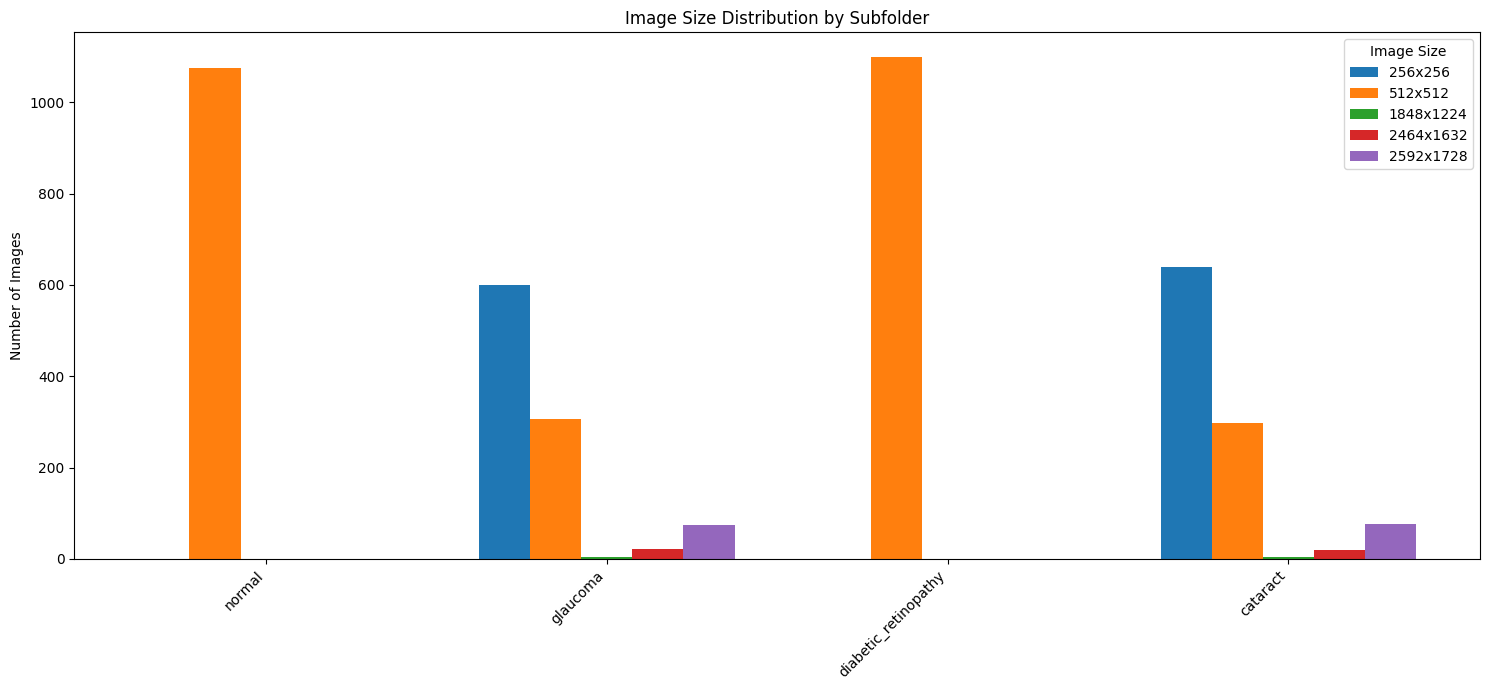

In [9]:
dataset_size_analysis_by_class(path)

Muestras del dataset aleatorias

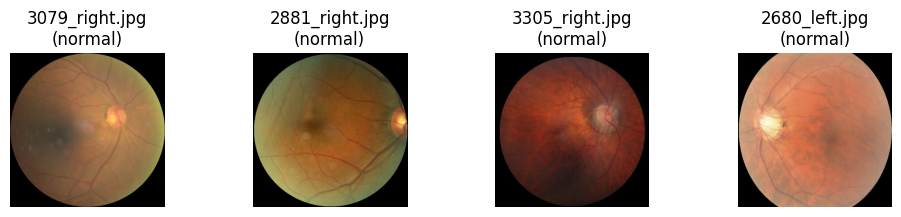

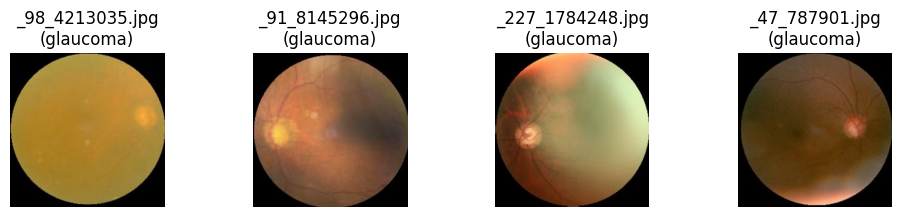

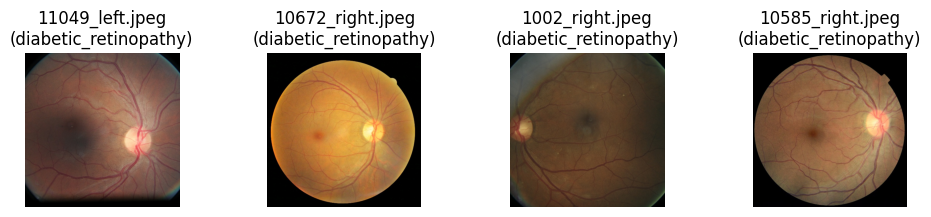

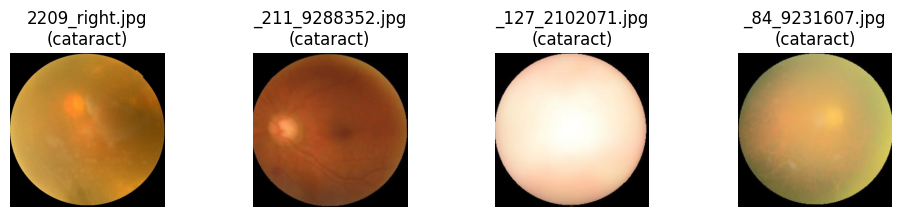

In [10]:
random_photos_from_folders(path)

# Data preparation

Establecemos nombre de clases y creamos un dataframe

In [11]:
# Getting the names of classes
class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# create data path and their labeles
data = []
labels = []
extensions = ["jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "bmp", "BMP", "gif", "GIF"]

for i in class_dirs:
    class_label = i
    image_files = []
    for ext in extensions:
        # Search for files with each extension and extend the image_files list
        image_files.extend(glob.glob(os.path.join(path, i, f"*.{ext}")))
    data.extend(image_files)
    labels.extend([class_label] * len(image_files))

# Check if lists are still empty
if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print("Files found and listed.")


# Create a DataFrame with the image paths and labels
df = pd.DataFrame({
'filename': data,
'class': labels
})


# Shuffle the dataset by rows
df = df.sample(frac=1)

Files found and listed.


In [12]:
display(df)

filename                 class
1696  /content/drive/MyDrive/dataset_enfermedades_oc...              glaucoma
2716  /content/drive/MyDrive/dataset_enfermedades_oc...  diabetic_retinopathy
4085  /content/drive/MyDrive/dataset_enfermedades_oc...              cataract
3395  /content/drive/MyDrive/dataset_enfermedades_oc...              cataract
3576  /content/drive/MyDrive/dataset_enfermedades_oc...              cataract
...                                                 ...                   ...
1591  /content/drive/MyDrive/dataset_enfermedades_oc...              glaucoma
3674  /content/drive/MyDrive/dataset_enfermedades_oc...              cataract
190   /content/drive/MyDrive/dataset_enfermedades_oc...                normal
4054  /content/drive/MyDrive/dataset_enfermedades_oc...              cataract
3190  /content/drive/MyDrive/dataset_enfermedades_oc...              cataract

[4217 rows x 2 columns]

In [13]:
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform((df['class']))
df['class'] = label

# check number assigned to each class
# Get the class names and corresponding integer encodings
class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)

{'cataract': np.int64(0), 'diabetic_retinopathy': np.int64(1), 'glaucoma': np.int64(2), 'normal': np.int64(3)}


# Dividimos los datos en (train, validation, test)

Al dividir los datos en tres partes, es importante mantener la proporción de distribución del conjunto de datos original. Esto se debe a que queremos que las tres partes (entrenamiento, validación y prueba) conserven la misma proporción de datos y que haya la misma cantidad de datos de entrenamiento para cada clase.

In [14]:
# Check the balance of the classes
print(df['class'].value_counts(normalize=True))
print('------'*10)

# Split the data into train+validation and test sets
train_plus_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train+validation set into train and validation sets
train, val = train_test_split(train_plus_val, test_size=0.25, stratify=train_plus_val['class'], random_state=42)
# 0.25 x 0.8 = 0.2

# Now you have:
# train: 60% of the data
# val: 20% of the data
# test: 20% of the data

# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts(normalize=True))
print('------'*10)


print("Validation set:")
print(val['class'].value_counts(normalize=True))
print('------'*10)


print("Test set:")
print(test['class'].value_counts(normalize=True))

class
1    0.260375
3    0.254683
0    0.246147
2    0.238795
Name: proportion, dtype: float64
------------------------------------------------------------
Training set:
class
1    0.260182
3    0.254646
0    0.245947
2    0.239225
Name: proportion, dtype: float64
------------------------------------------------------------
Validation set:
class
1    0.260664
3    0.254739
0    0.246445
2    0.238152
Name: proportion, dtype: float64
------------------------------------------------------------
Test set:
class
1    0.260664
3    0.254739
0    0.246445
2    0.238152
Name: proportion, dtype: float64


In [15]:
train_links, train_labels = train['filename'].values , train['class'].values
val_links , val_labels = val['filename'].values , val['class'].values
test_links, test_labels = test['filename'].values , test['class'].values

# Carga y preprocesamiento de imágenes, creación de los objetos dataset

Función de carga de imágenes y posibilidad de aplicar data augmentation

In [16]:
def create_dataset(links, labels, image_size=(150, 150), data_augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices((links, labels))
    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(
            x, y,
            image_size=image_size,
            data_augmentation=data_augmentation
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset

Creamos nuestro dataset con dimensiones (256,256) ya que es el tamaño de imagen predominante.

In [17]:
image_size = (256, 256)
batch_size = 32
data_augmentation = False   #Sin augmentation
train_ds = create_dataset(train_links, train_labels,
                              image_size=image_size,
                              data_augmentation=data_augmentation)
val_ds   = create_dataset(val_links, val_labels,
                              image_size=image_size,
                              data_augmentation=False)
test_ds  = create_dataset(test_links, test_labels,
                              image_size=image_size,
                              data_augmentation=False)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


# Creando el modelo
Ejecuta la sección y se obtiene el objeto modelo

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, DenseNet121

## efficientnetb3

91.94%

In [ ]:
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(class_names) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

## ResNet50V2

91.23%

In [ ]:
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(class_names)  # Asegúrate de tener esta variable definida

# Crear modelo base pre-entrenado: ResNet50V2
base_model = ResNet50V2(include_top=False,
                      weights='imagenet',
                      input_shape=img_shape)

# Congelar las capas del modelo base (opcional, puedes ajustar esto)
# Si tu dataset es pequeño, es recomendable congelar para evitar overfitting
for layer in base_model.layers:
    layer.trainable = False

# Construir el modelo completo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256,
          activation='relu'),
    Dropout(rate=0.4, seed=123),
    Dense(class_count, activation='softmax')
])

# Mostrar resumen del modelo
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,564 (91.93 MB)

 Trainable params: 529,668 (2.02 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

## MobileNetV2

93.01%

In [ ]:
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(class_names)  # Asegúrate de tener esta variable definida

# Crear modelo base pre-entrenado: MobileNetV2
base_model = MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_shape=img_shape)

# Congelar las primeras N capas del modelo base
# Ajusta este valor según el tamaño de tu conjunto de datos
N = int(len(base_model.layers) * 0.7)  # Congela el 70% inicial de las capas
for layer in base_model.layers[:N]:
    layer.trainable = False

# Construir el modelo usando la API funcional para más flexibilidad
inputs = Input(shape=img_shape)
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Primera rama densa
x1 = Dense(384, activation='relu',
          kernel_regularizer=regularizers.l2(0.01))(x)
x1 = Dropout(0.35)(x1)

# Segunda rama densa
x2 = Dense(384, activation='relu',
          kernel_regularizer=regularizers.l2(0.01))(x)
x2 = Dropout(0.35)(x2)

# Combinar las ramas
combined = tf.keras.layers.Concatenate()([x1, x2])

# Capa de fusión
x = Dense(256, activation='relu',
         kernel_regularizer=regularizers.l2(0.01))(combined)
x = Dropout(0.3)(x)

# Capa de salida
outputs = Dense(class_count, activation='softmax')(x)

# Crear modelo completo
model = Model(inputs=inputs, outputs=outputs)

# Mostrar resumen del modelo
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 8, 8,      │  2,257,984 │ input_layer_7[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 384)       │    491,904 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 384)       │    491,904 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 384)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 384)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │      1,028 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,444,804 (13.14 MB)

 Trainable params: 2,983,876 (11.38 MB)

 Non-trainable params: 460,928 (1.76 MB)

## DenseNet121

94.19 %

In [20]:
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(class_names)  # Asegúrate de tener esta variable definida


# Crear modelo base pre-entrenado: DenseNet121
base_model = DenseNet121(include_top=False,
                        weights='imagenet',
                        input_shape=img_shape)

# Congelar las capas del modelo base excepto los últimos bloques densos
# DenseNet121 tiene 4 bloques densos, descongelamos solo el último
for layer in base_model.layers[:-20]:  # Ajusta este número según sea necesario
    layer.trainable = False

# Feature pyramid: extraer características de diferentes niveles de la red
# Esta técnica ayuda a mejorar el rendimiento y la estabilidad
input_tensor = Input(shape=img_shape)
x = base_model(input_tensor)

# Añadir normalización de lotes para estabilizar el entrenamiento
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = GlobalAveragePooling2D()(x)

# Añadir un cabezal de clasificación con varias capas y fuerte regularización

x = Dense(256, activation='relu',
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
         kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Capa de salida con inicialización cuidadosa
outputs = Dense(class_count,
               activation='softmax',
               kernel_initializer=tf.keras.initializers.GlorotUniform())(x)

# Crear modelo completo
model = Model(inputs=input_tensor, outputs=outputs)

# Mostrar resumen del modelo
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,306,052 (27.87 MB)

 Trainable params: 633,156 (2.42 MB)

 Non-trainable params: 6,672,896 (25.46 MB)

Función para crear variaciones de DenseNet121

In [21]:
def build_model_DenseNet(
    img_size=(256, 256),
    channels=3,
    class_count=4,       # reemplaza con len(class_names)
    freeze_blocks=20,     # número de capas a dejar congeladas
    l1=1e-5,
    l2=1e-4,
    dropout_rate=0.6,
    mixup_scale=0.1,
    dense_units=256,
    initializer_seed=42
):
    """
    Construye un modelo basado en DenseNet121 + cabeza personalizada.
    - Congela todas las capas menos las últimas `freeze_blocks`.
    - Añade BatchNorm, GlobalAvgPool, Dense + regularización, Dropout y un Lambda de mixup.
    """
    img_shape = (*img_size, channels)

    # Modelo base
    base = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape
    )

    # Congelar capas
    for layer in base.layers[:-freeze_blocks]:
        layer.trainable = False

    # Cabeza
    inp = Input(shape=img_shape)
    x = base(inp)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        dense_units,
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2),
        kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(
        class_count,
        activation="softmax",
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=initializer_seed)
    )(x)

    return Model(inputs=inp, outputs=out)

## Custom model

Modelo personalizado de desarrollo propio

91.23%

In [ ]:
model = models.Sequential([
    # First Block
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),


    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Third Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Fourth Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),



    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 62, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 58, 58, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 29, 29, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 29, 29, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 27, 27, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,533,956 (13.48 MB)

 Trainable params: 3,532,164 (13.47 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Entrenando el modelo


In [22]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    TerminateOnNaN
)
import tensorflow as tf
import os
import math
import time
from tensorflow.keras.optimizers import Adam, Adamax

**Creamos DenseNet121**. Los parámetros que se encuentran declarados son los más recomendables. No obstante, se pueden modificar buscando mejoras.

In [23]:
model=build_model_DenseNet(
    img_size=(256, 256),
    channels=3,
    class_count=len(class_names),
    freeze_blocks=20,     # número de capas a dejar congeladas
    l1=1e-3,
    l2=1e-3,
    dropout_rate=0.7,
    mixup_scale=0.1,
    dense_units=128,
    initializer_seed=None
)

Resumen del modelo

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,173,828 (27.37 MB)

 Trainable params: 501,188 (1.91 MB)

 Non-trainable params: 6,672,640 (25.45 MB)

Función para entrenar el modelo

In [25]:
def train(
    model,
    train_links, train_labels,
    val_links,   val_labels,
    test_links,  test_labels,
    image_size=(256,256),
    batch_size=16,
    data_augmentation=True,
    base_dir=None,
    max_epochs=200,
    patience=30,
    min_delta=0.001,
    learning_rate=0.001,
    optimizer='adamax'  # Nuevo parámetro para seleccionar el optimizador
):
    """
    Entrena `model` con un batch size dado, guarda sólo el mejor peso por run,
    y devuelve el modelo entrenado junto al batch_size usado.

    Parameters:
    -----------
    model : modelo Keras
        Modelo a entrenar
    train_links, train_labels : listas
        Paths de imágenes y etiquetas de entrenamiento
    val_links, val_labels : listas
        Paths de imágenes y etiquetas de validación
    test_links, test_labels : listas
        Paths de imágenes y etiquetas de test
    image_size : tuple
        Tamaño de las imágenes (altura, anchura)
    batch_size : int
        Tamaño del batch para entrenamiento
    data_augmentation : bool
        Si se aplica data augmentation al conjunto de entrenamiento
    base_dir : str
        Directorio base para guardar modelos
    max_epochs : int
        Número máximo de épocas de entrenamiento
    patience : int
        Número de épocas para early stopping
    min_delta : float
        Mínimo cambio para considerar mejoría en early stopping
    learning_rate : float
        Tasa de aprendizaje para el optimizador
    optimizer : str
        Tipo de optimizador a usar. Opciones: 'adam', 'adamax', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'nadam'

    Returns:
    --------
    model : modelo Keras entrenado
    batch_size : int
        Batch size usado
    history : History
        Historial de entrenamiento
    """
    import tensorflow as tf
    import os
    import time
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
    from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop, Adagrad, Adadelta, Nadam

    # 1) Crear datasets y batching/prefetch
    train_ds = create_dataset(train_links, train_labels,
                              image_size=image_size,
                              data_augmentation=data_augmentation)
    val_ds   = create_dataset(val_links, val_labels,
                              image_size=image_size,
                              data_augmentation=False)
    test_ds  = create_dataset(test_links, test_labels,
                              image_size=image_size,
                              data_augmentation=False)

    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # 2) Directorio para guardar modelos
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    if base_dir is None:
        base_dir = os.path.join(os.getcwd(), "models")
    # Incluir el optimizador en el nombre del directorio
    exp_dir = os.path.join(base_dir, f"{optimizer}_bs{batch_size}_{timestamp}")
    os.makedirs(exp_dir, exist_ok=True)

    # 3) Callbacks
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        min_delta=min_delta,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
    chkpt = ModelCheckpoint(
        filepath=os.path.join(exp_dir, f"{optimizer}_epoch{{epoch:02d}}_valacc{{val_accuracy:.4f}}.keras"),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    term_nan = TerminateOnNaN()

    # 4) Selección del optimizador
    optimizer_dict = {
        'adam': Adam(learning_rate=learning_rate),
        'adamax': Adamax(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        'rmsprop': RMSprop(learning_rate=learning_rate, rho=0.9),
        'adagrad': Adagrad(learning_rate=learning_rate),
        'adadelta': Adadelta(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate)
    }

    # Verificar que el optimizador solicitado es válido
    if optimizer.lower() not in optimizer_dict:
        print(f"Optimizador '{optimizer}' no reconocido. Usando Adamax por defecto.")
        selected_optimizer = optimizer_dict['adamax']
        optimizer = 'adamax'  # Actualizar el nombre para los registros
    else:
        selected_optimizer = optimizer_dict[optimizer.lower()]

    print(f"Usando optimizador: {optimizer}")

    # 5) Compilación
    model.compile(
        optimizer=selected_optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 6) Entrenamiento
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=max_epochs,
        callbacks=[early_stop, chkpt, term_nan],
        verbose=1
    )

    print(f"\nEntrenamiento terminado con batch_size={batch_size} y optimizador={optimizer}")
    print(f"Mejor modelo guardado en: {exp_dir}")

    # 7) Evaluar el modelo en el conjunto de test
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
    print(f"Rendimiento en test: Loss = {test_loss:.4f}, Accuracy = {test_accuracy:.4f}")

    # 8) Devolver modelo (con pesos restaurados), batch_size, y history
    return model, batch_size, history

Entrenamos Modelo

In [ ]:
trained_model, batch_size, history=train(
    model,
    train_links, train_labels,
    val_links,   val_labels,
    test_links,  test_labels,
    image_size=(256,256),
    batch_size=32,
    data_augmentation=True,
    base_dir=None,
    max_epochs=65,
    patience=30,
    min_delta=0.001,
    learning_rate=0.001
)

Usando optimizador: adamax
Epoch 1/65
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5972 - loss: 5.9697
Epoch 1: val_accuracy improved from -inf to 0.84953, saving model to /content/models/adamax_bs32_20250513-131630/adamax_epoch01_valacc0.8495.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 88s 593ms/step - accuracy: 0.5983 - loss: 5.9630 - val_accuracy: 0.8495 - val_loss: 4.4725
Epoch 2/65
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7975 - loss: 4.4418
Epoch 2: val_accuracy improved from 0.84953 to 0.88981, saving model to /content/models/adamax_bs32_20250513-131630/adamax_epoch02_valacc0.8898.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7977 - loss: 4.4377 - val_accuracy: 0.8898 - val_loss: 3.8331
Epoch 3/65
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8605 - loss: 3.8145
Epoch 3: val_accuracy improved from 0.88981 to 0.89455, saving model to /content/models/adamax_bs32_20250513-131630/adamax_epoch03_valacc0.8945.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/s

In [ ]:
nombre_modelo="DenseNet121_0.9419.keras"
trained_model.save(nombre_modelo)

Evolución del entrenamiento

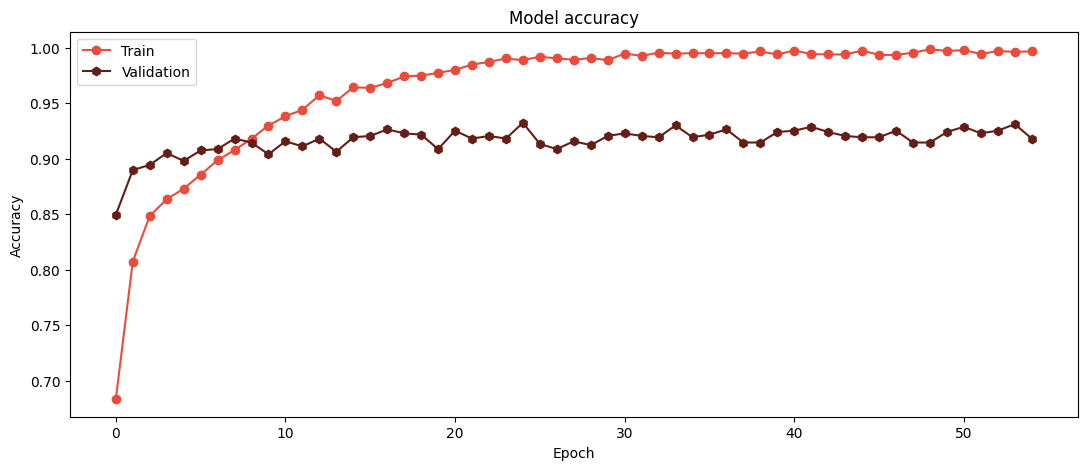

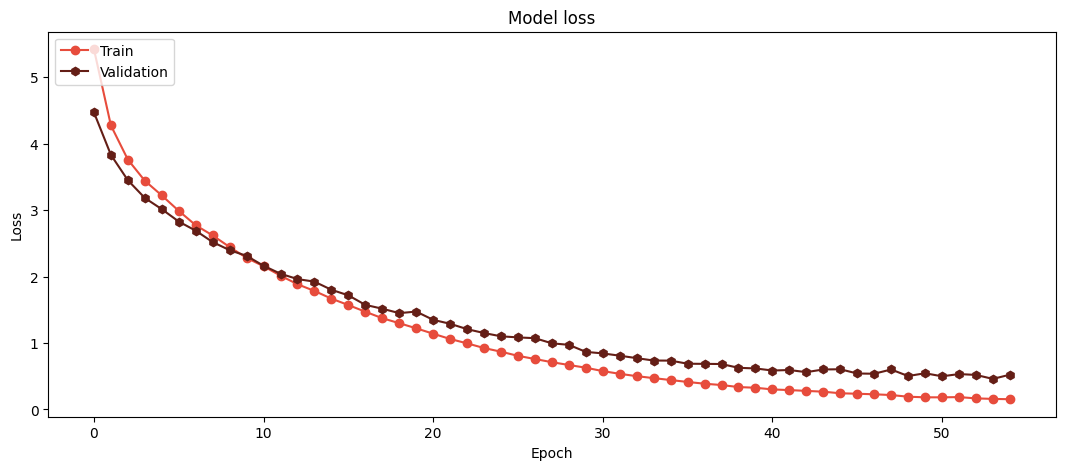

In [ ]:
# Plot training & validation accuracy values
plot_training_history(history, figsize=(13, 5))

# Resultados del entrenamiento

In [26]:
from tensorflow.keras import backend as K

En caso de que tengamos el modelo entrenado en nuestro directorio

In [27]:
nombre_modelo="DenseNet121_0.9419.keras"
trained_model = tf.keras.models.load_model(nombre_modelo, safe_mode=False)

Resumen del modelo

In [28]:
analizar_modelo_densenet(trained_model)

Análisis del modelo: functional_2
--------------------------------------------------
Total parámetros: 7,173,828
Parámetros entrenables: 501,188
Parámetros no entrenables: 6,672,640
Forma de entrada: (None, 256, 256, 3)
Forma de salida: (None, 4)

Distribución de capas:
  - InputLayer: 1
  - Functional: 1
  - BatchNormalization: 2
  - GlobalAveragePooling2D: 1
  - Dense: 2
  - Dropout: 1

Bloques densos:


{'nombre': 'functional_2',
 'numero_capas': 8,
 'parametros_totales': 7173828,
 'parametros_entrenables': 501188,
 'parametros_no_entrenables': 6672640,
 'tipo_entrada': '(None, 256, 256, 3)',
 'tipo_salida': '(None, 4)',
 'capas_por_tipo': {'InputLayer': 1,
  'Functional': 1,
  'BatchNormalization': 2,
  'GlobalAveragePooling2D': 1,
  'Dense': 2,
  'Dropout': 1},
 'bloques_densos': []}

Creamos la matriz de confución y realizamos el reporte

In [29]:
# Get the predicted labels from the model

y_pred = np.argmax(trained_model.predict(test_ds) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 808ms/step
Confusion Matrix:
[[206   0   1   1]
 [  0 220   0   0]
 [  3   0 191   7]
 [  1   0   8 206]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.99       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.95      0.95      0.95       201
              normal       0.96      0.96      0.96       215

            accuracy                           0.98       844
           macro avg       0.97      0.97      0.97       844
        weighted avg       0.98      0.98      0.98       844



Algunas gráficas de los resultados

Total de muestras de prueba: 844

Informe de clasificación:
                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.99       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.95      0.95      0.95       201
              normal       0.96      0.96      0.96       215

            accuracy                           0.98       844
           macro avg       0.97      0.97      0.97       844
        weighted avg       0.98      0.98      0.98       844


Clases más difíciles de clasificar:
               Clase  Exactitud  Total Muestras  Errores  Tasa de Error
            glaucoma   0.950249             201       10       0.049751
              normal   0.958140             215        9       0.041860
            cataract   0.990385             208        2       0.009615
diabetic_retinopathy   1.000000             220        0       0.000000

Recomendaciones:
- Considerar aumentar los 

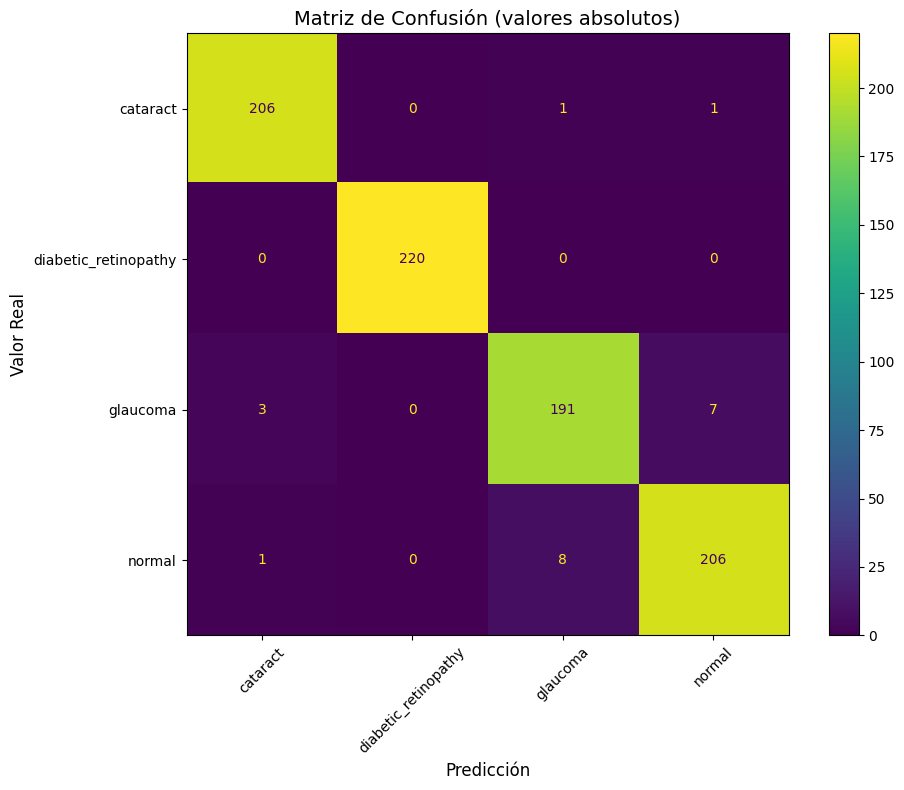

In [33]:
# Para generar solo la matriz de confusión con valores absolutos
fig_abs, _ = analizar_resultados_modelo(y_true, y_pred, label_encoder, plot_type='absolute')

Total de muestras de prueba: 844

Informe de clasificación:
                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.99       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.95      0.95      0.95       201
              normal       0.96      0.96      0.96       215

            accuracy                           0.98       844
           macro avg       0.97      0.97      0.97       844
        weighted avg       0.98      0.98      0.98       844


Clases más difíciles de clasificar:
               Clase  Exactitud  Total Muestras  Errores  Tasa de Error
            glaucoma   0.950249             201       10       0.049751
              normal   0.958140             215        9       0.041860
            cataract   0.990385             208        2       0.009615
diabetic_retinopathy   1.000000             220        0       0.000000

Recomendaciones:
- Considerar aumentar los 

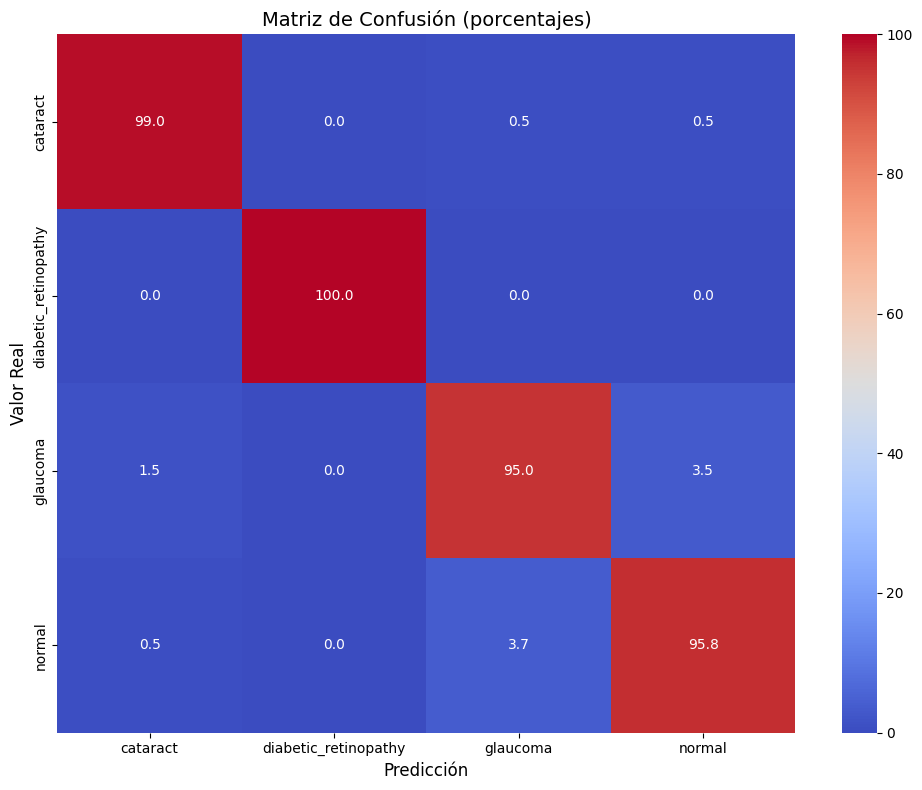

In [34]:
# Para generar solo la matriz de confusión con porcentajes
fig_pct, _ = analizar_resultados_modelo(y_true, y_pred, label_encoder, plot_type='percentage')

Total de muestras de prueba: 844

Informe de clasificación:
                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.99       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.95      0.95      0.95       201
              normal       0.96      0.96      0.96       215

            accuracy                           0.98       844
           macro avg       0.97      0.97      0.97       844
        weighted avg       0.98      0.98      0.98       844


Clases más difíciles de clasificar:
               Clase  Exactitud  Total Muestras  Errores  Tasa de Error
            glaucoma   0.950249             201       10       0.049751
              normal   0.958140             215        9       0.041860
            cataract   0.990385             208        2       0.009615
diabetic_retinopathy   1.000000             220        0       0.000000

Recomendaciones:
- Considerar aumentar los 

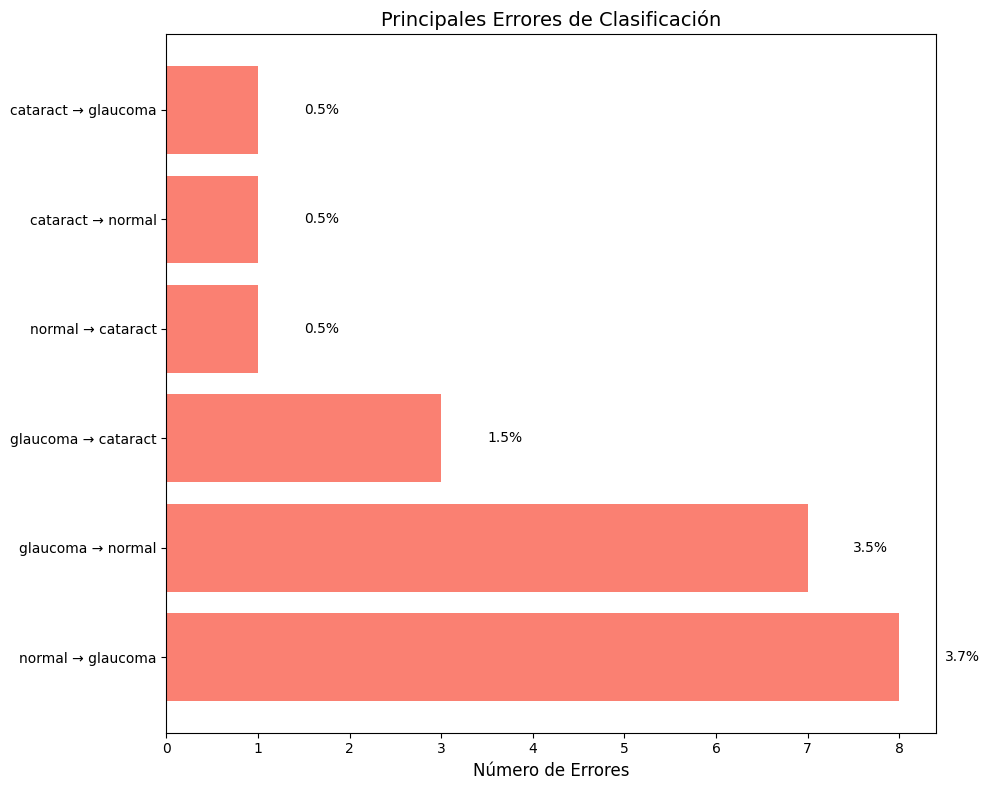

In [35]:
# Para generar solo el gráfico de errores principales
fig_err, _ = analizar_resultados_modelo(y_true, y_pred, label_encoder, plot_type='errors')

Total de muestras de prueba: 844

Informe de clasificación:
                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.99       208
diabetic_retinopathy       1.00      1.00      1.00       220
            glaucoma       0.95      0.95      0.95       201
              normal       0.96      0.96      0.96       215

            accuracy                           0.98       844
           macro avg       0.97      0.97      0.97       844
        weighted avg       0.98      0.98      0.98       844


Clases más difíciles de clasificar:
               Clase  Exactitud  Total Muestras  Errores  Tasa de Error
            glaucoma   0.950249             201       10       0.049751
              normal   0.958140             215        9       0.041860
            cataract   0.990385             208        2       0.009615
diabetic_retinopathy   1.000000             220        0       0.000000

Recomendaciones:
- Considerar aumentar los 

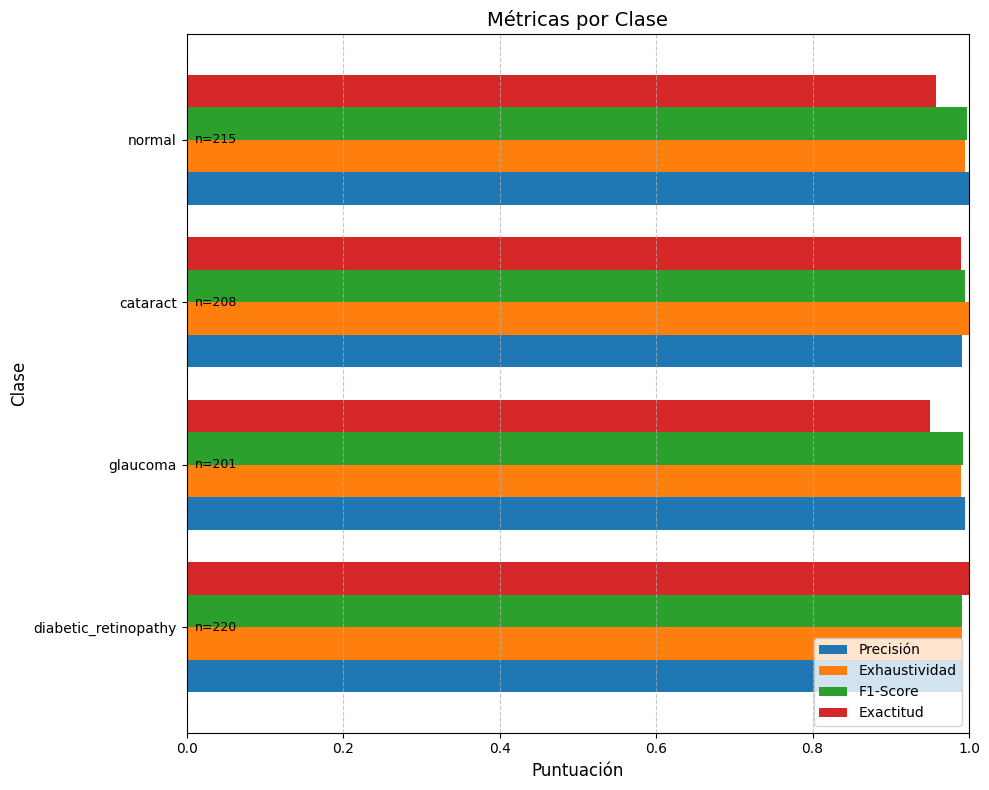

In [36]:
# Para generar solo el gráfico de métricas por clase
fig_met, _ = analizar_resultados_modelo(y_true, y_pred, label_encoder, plot_type='metrics')

In [38]:
trained_model.evaluate(test_ds)

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.9844 - loss: 0.1697


[0.20901711285114288, 0.9751184582710266]

Un 97.51 % de precisión !!!!

Realizar predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


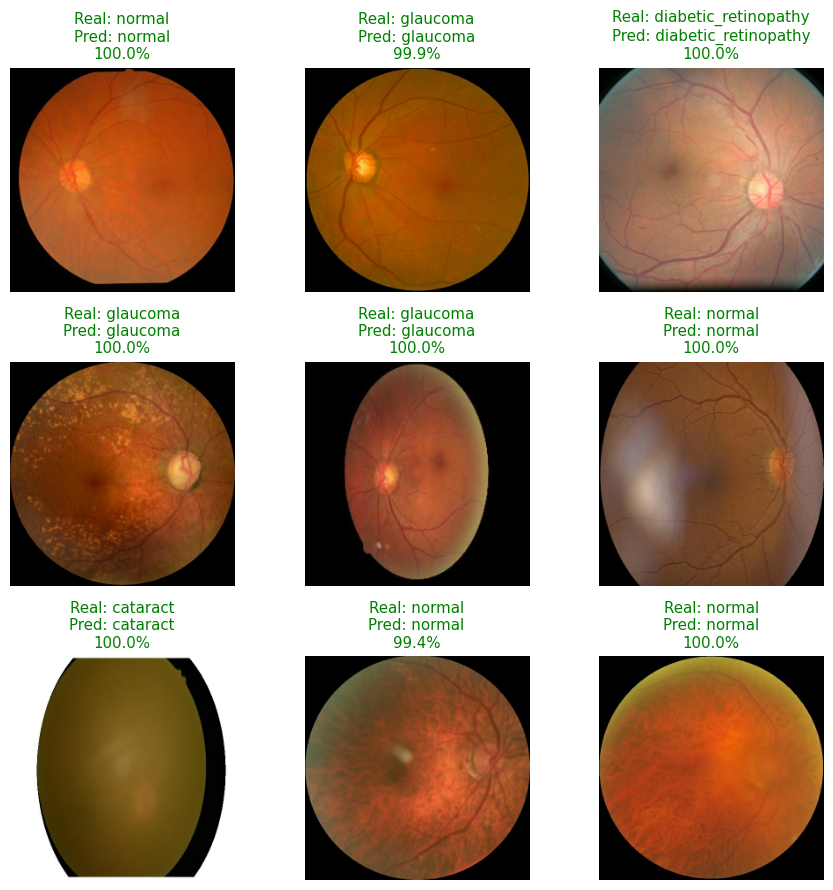

In [39]:
plot_test_predictions(trained_model, test_ds, class_labels, num_images=9, random_selection=True, cols=3)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step


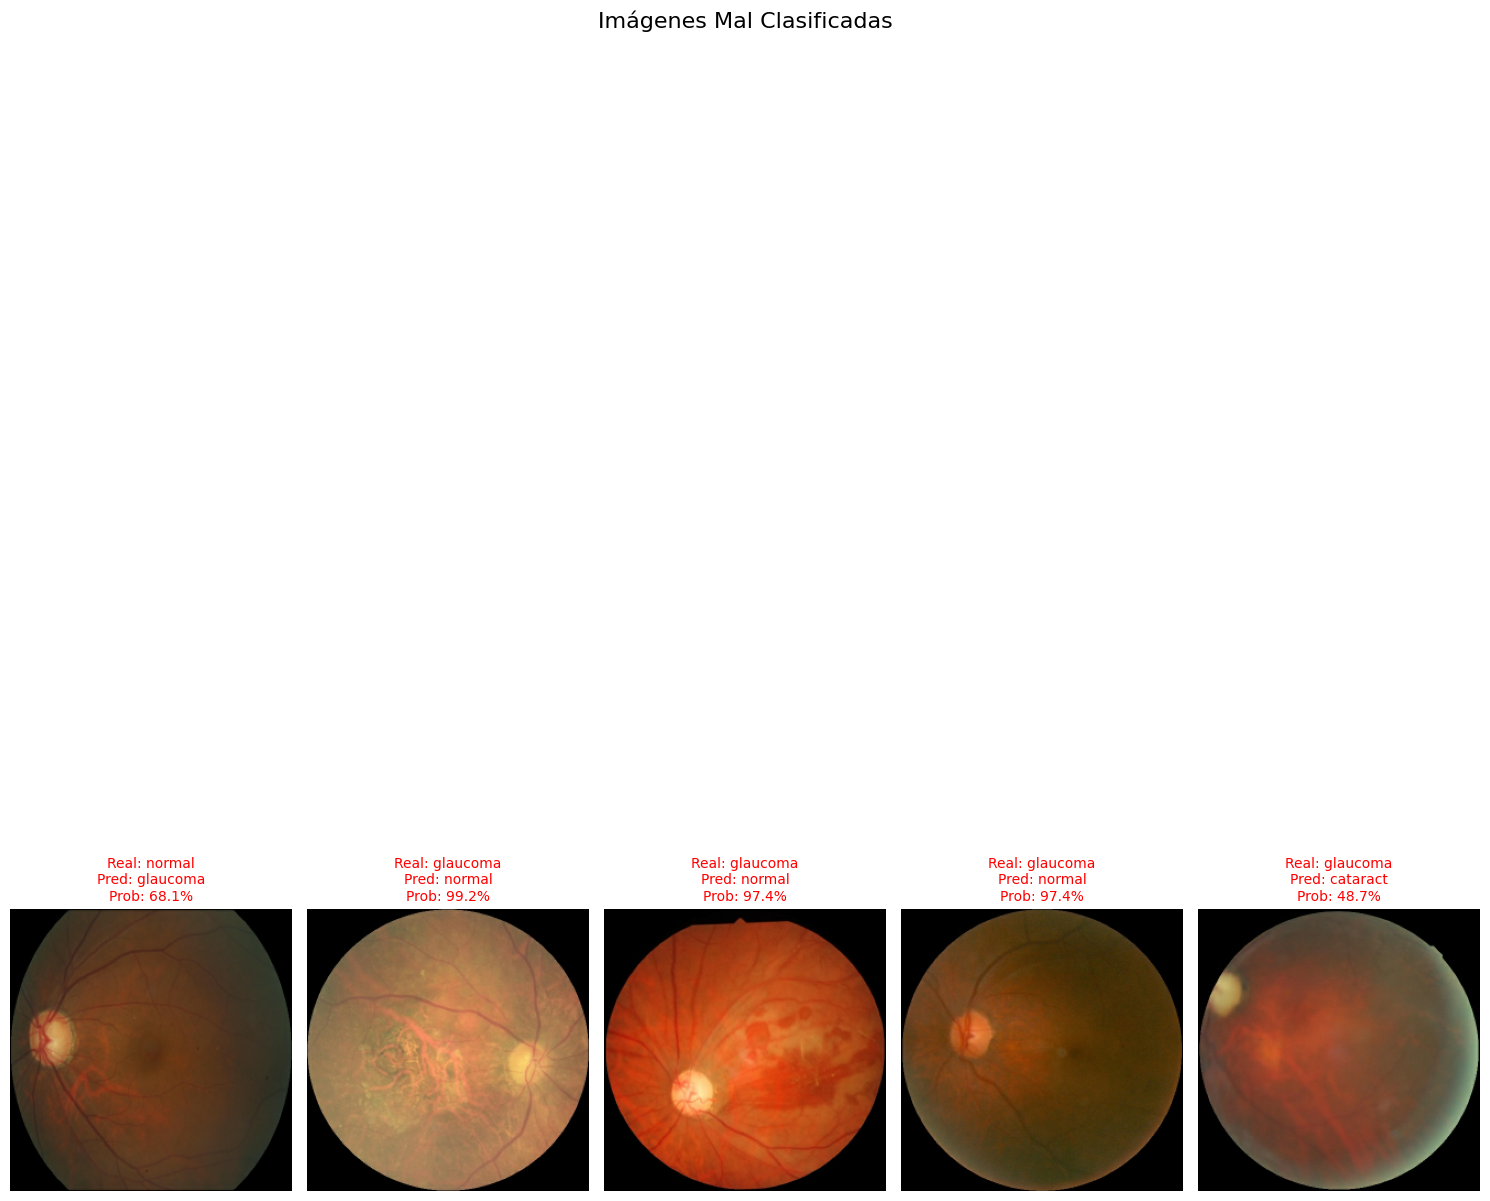

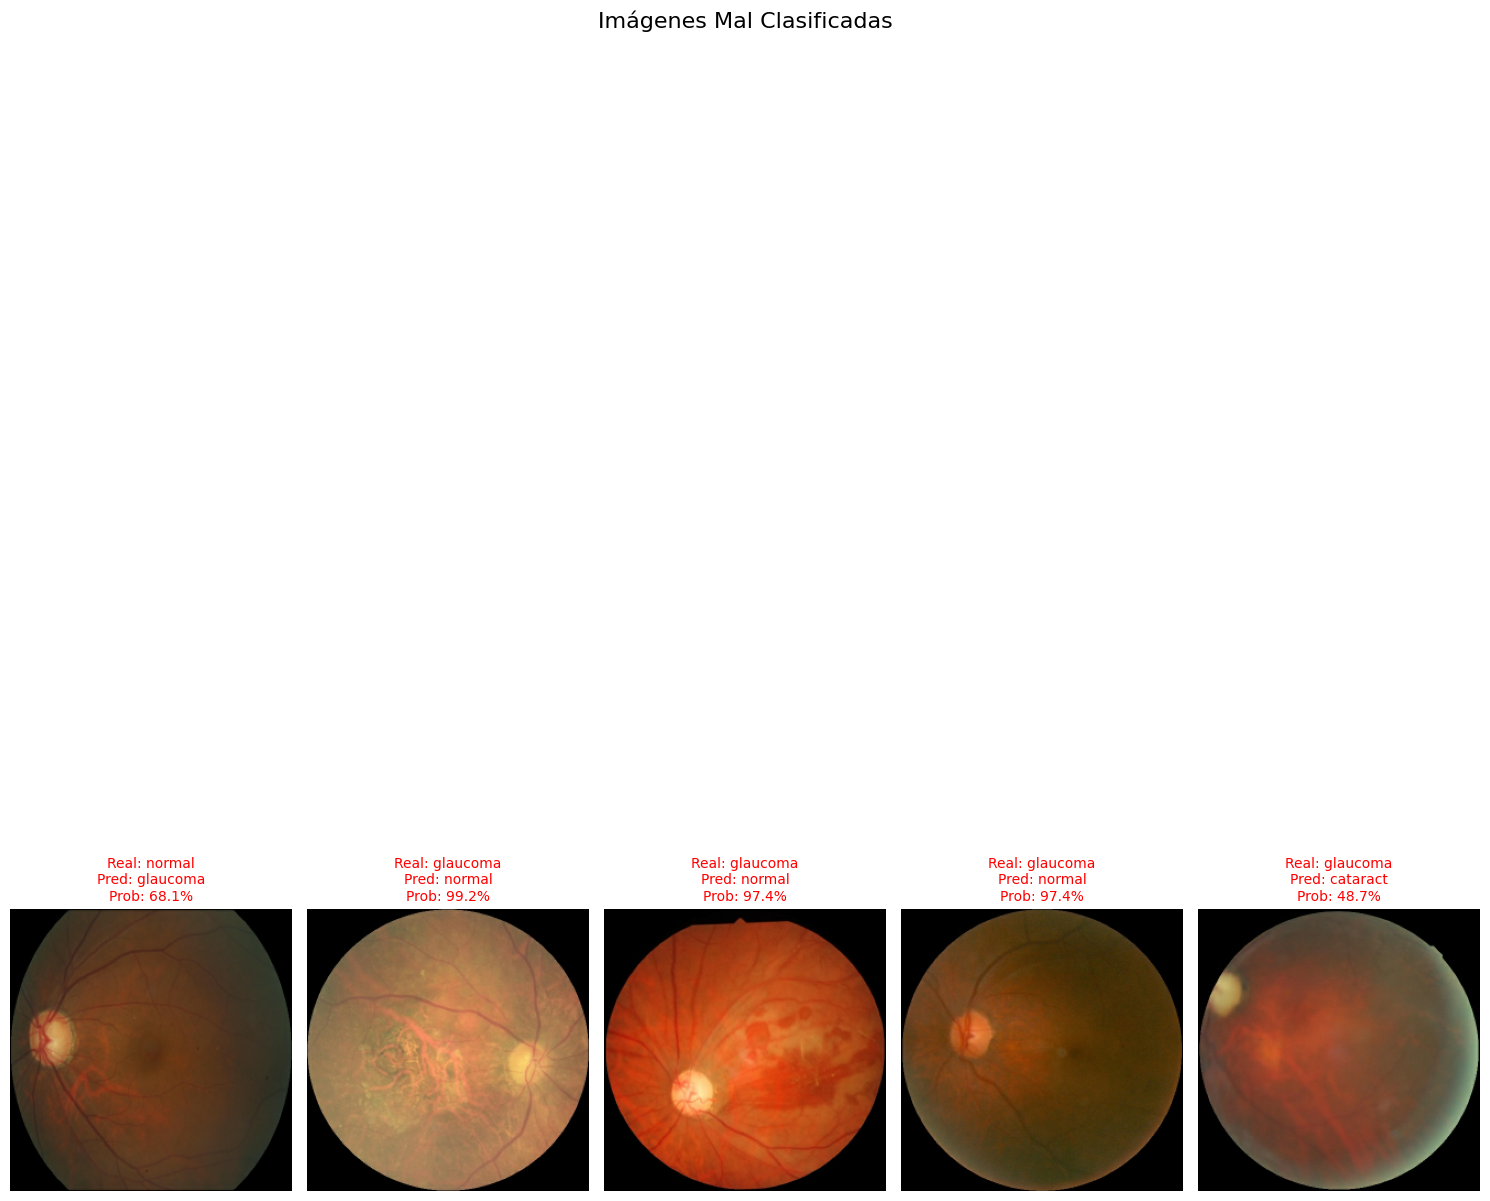

In [42]:
plot_misclassified_predictions(trained_model, test_ds, class_labels, num_images=5)

In [44]:
class_dict

{'cataract': np.int64(0),
 'diabetic_retinopathy': np.int64(1),
 'glaucoma': np.int64(2),
 'normal': np.int64(3)}

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


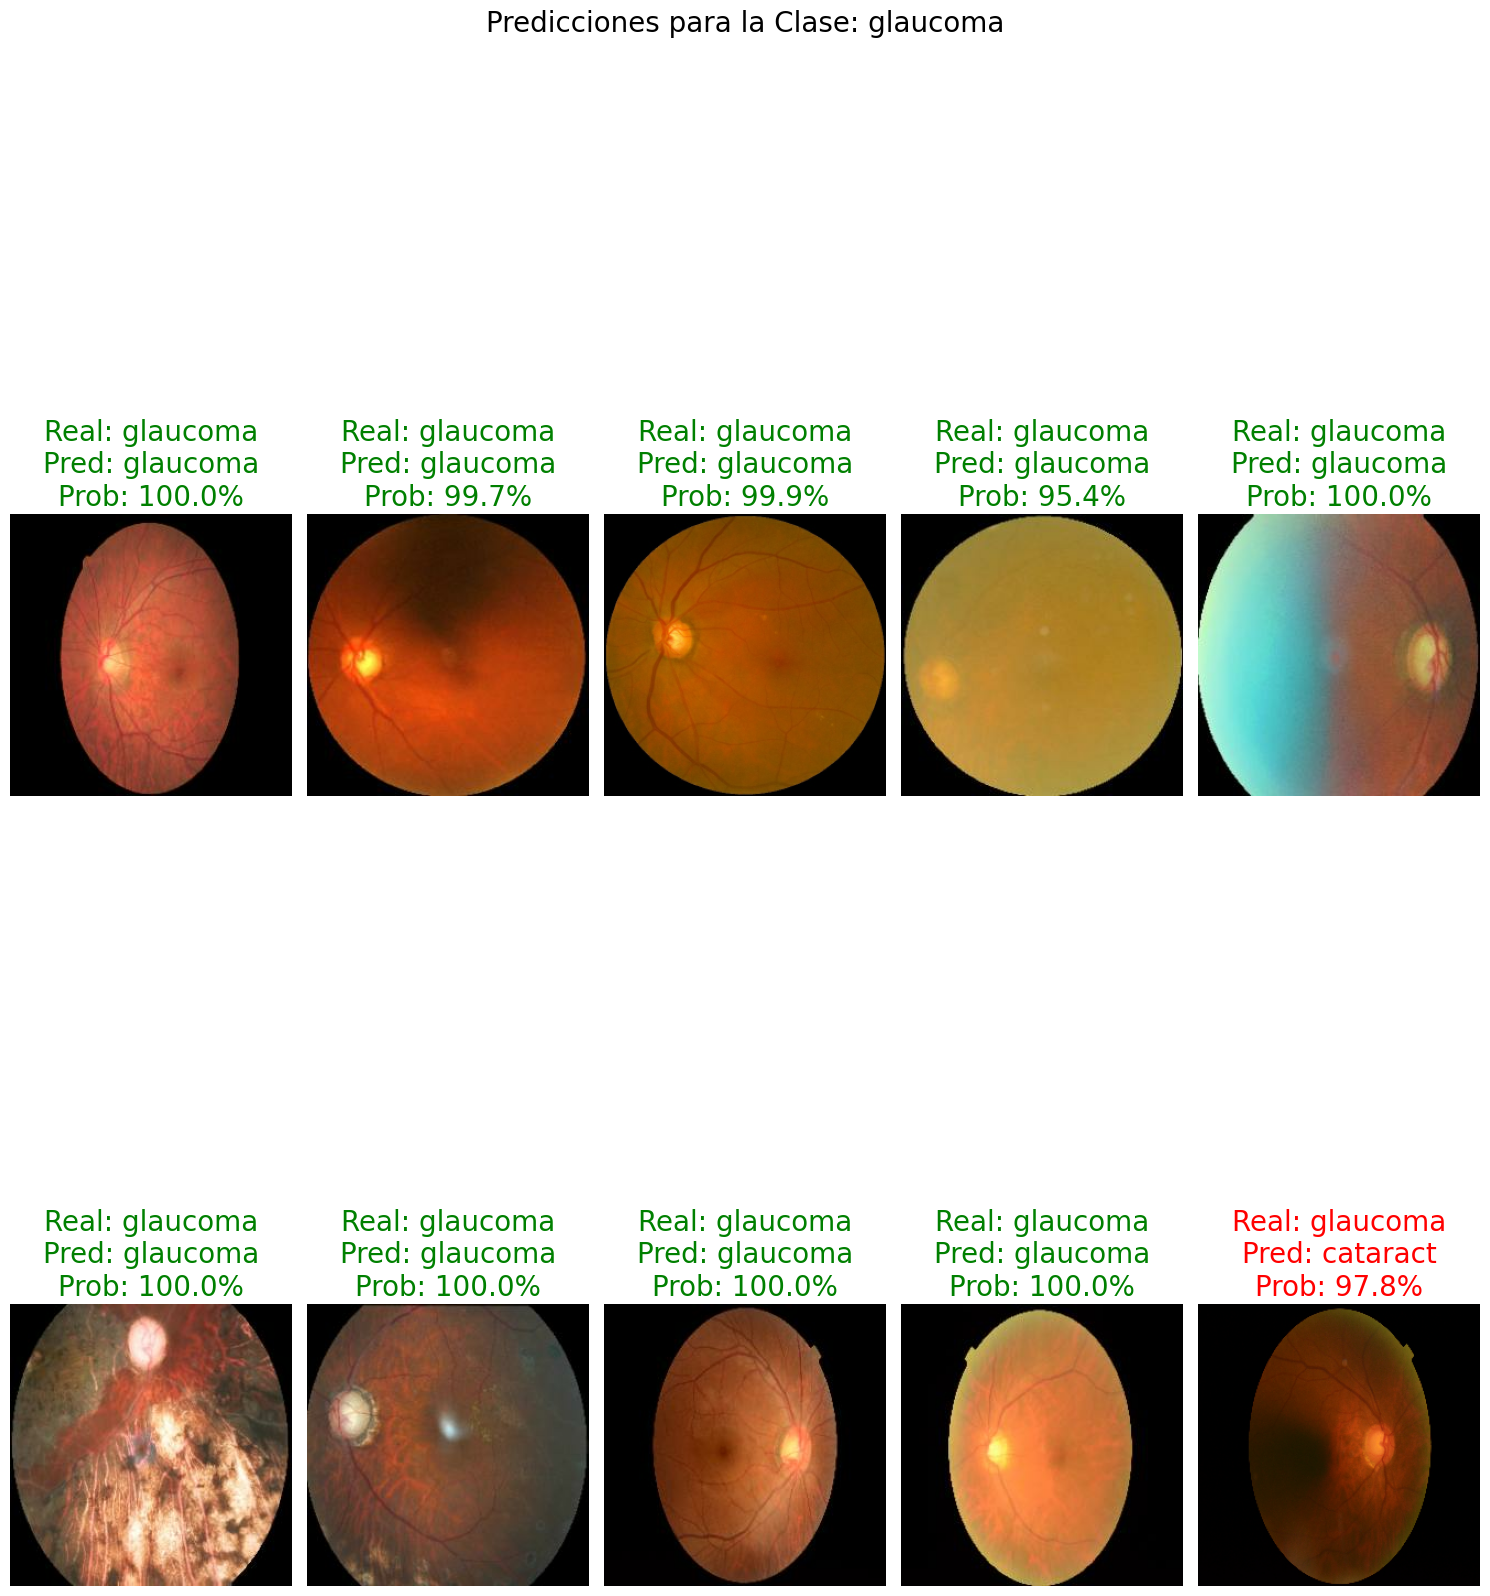

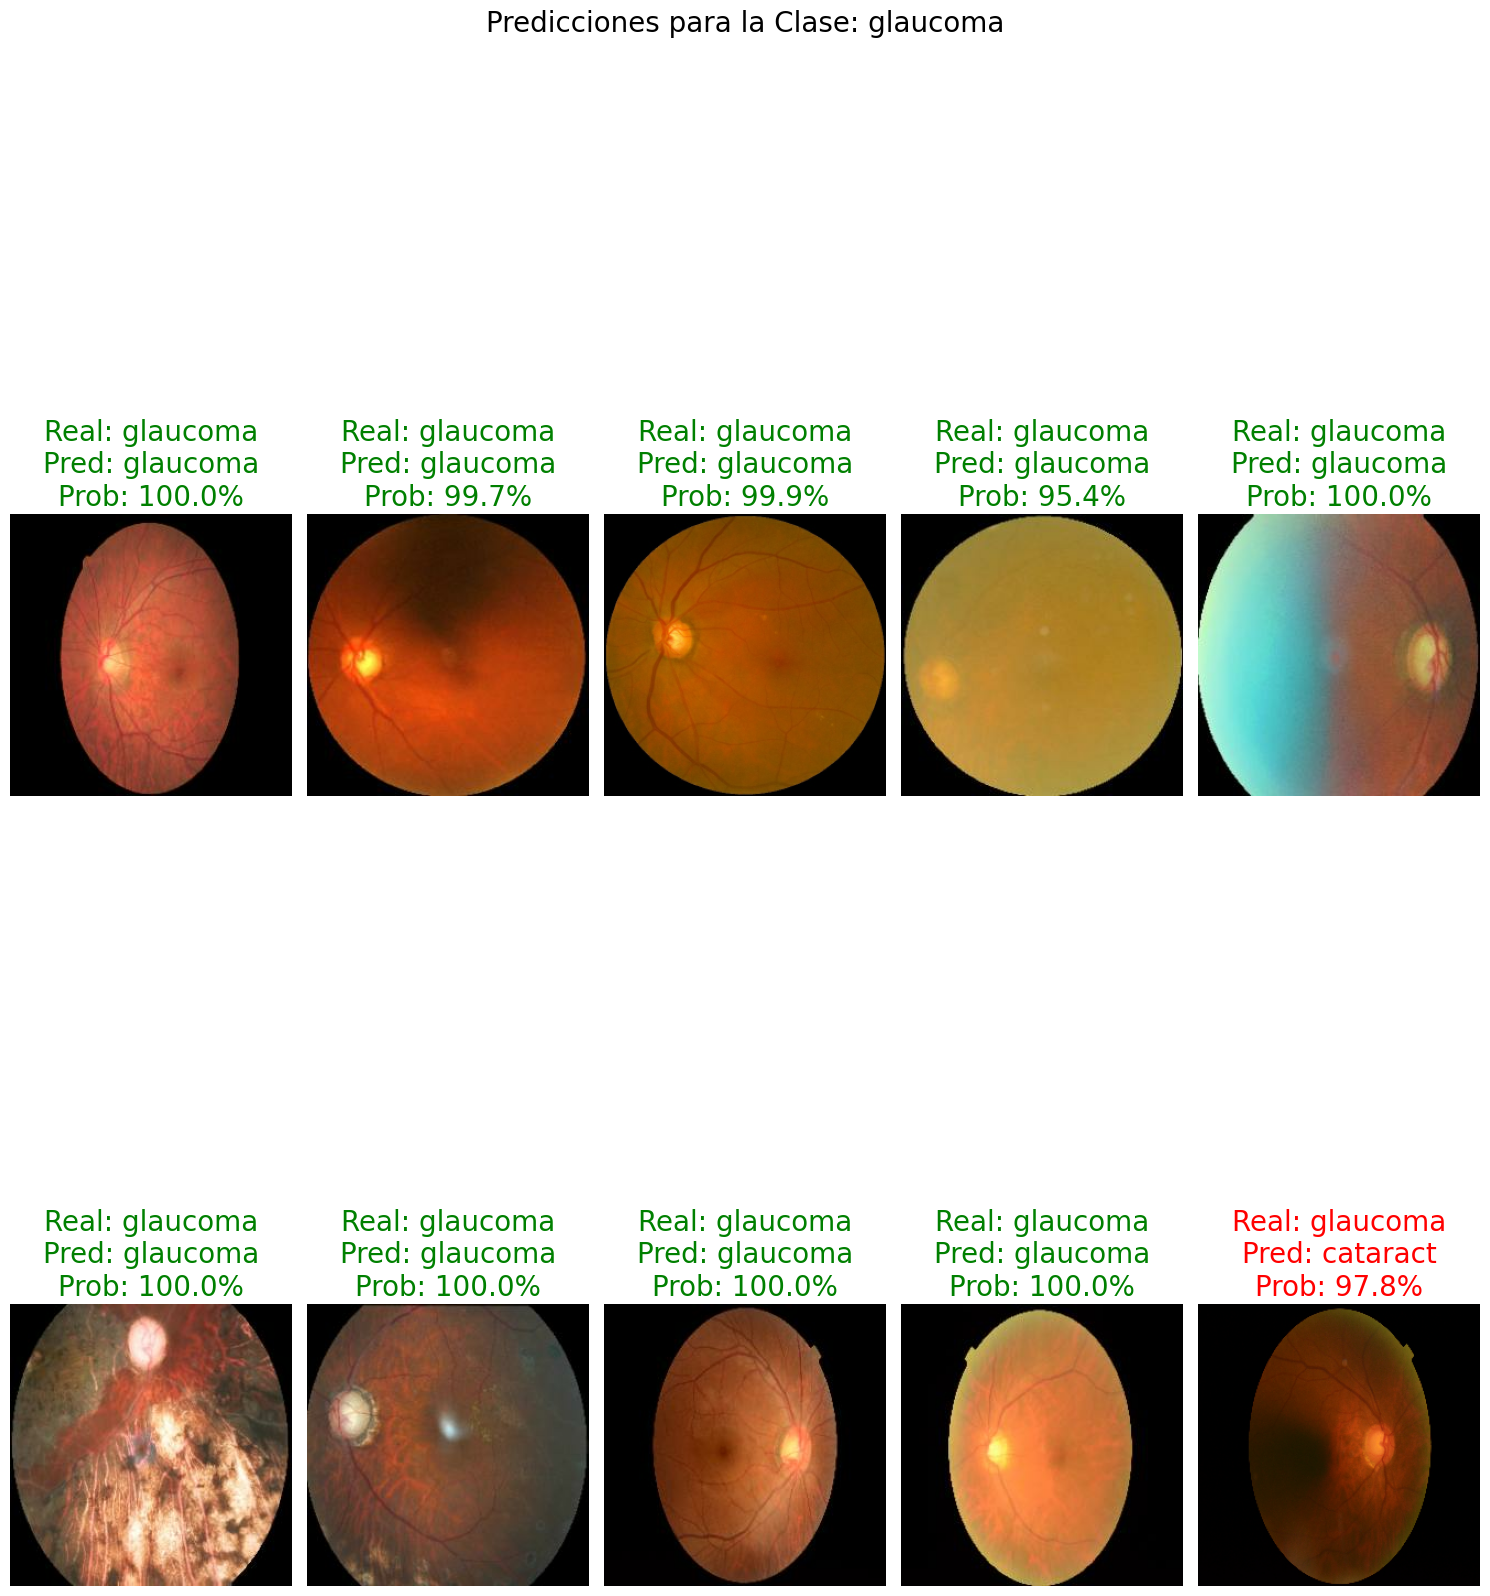

In [46]:
plot_predictions_by_class(trained_model, test_ds, class_labels, target_class=2, num_images=10, random_selection=True)  #clase de índice 2 glaucoma

# Hyperparameter tuning (sección experimental, no ejecutar)

Diferentes pruebas en función del modelo, tamaño del lote, número de neuronas ...

## Por modelo

In [ ]:
resultados={
    'efficientnetb3': 91.94,
    'ResNet50V2': 91.23,
    'MobileNetV2': 93.01,
    'DenseNet121': 93.72,
    'Custom_model': 91.23
}
modelos = list(resultados.keys())
scores = list(resultados.values())

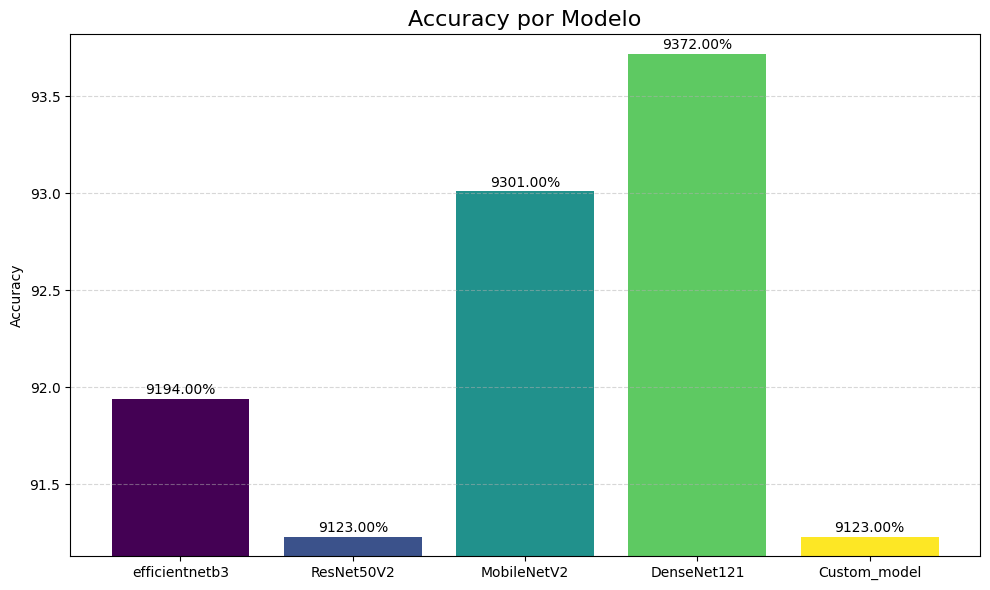

In [ ]:
# Colores gradientes según valor
colors = plt.cm.viridis(np.linspace(0, 1, len(scores)))

# Crear gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, scores, color=colors)

# Añadir etiquetas encima
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', va='bottom')

# Título y etiquetas
plt.title("Accuracy por Modelo", fontsize=16)
plt.ylabel("Accuracy")
plt.ylim(min(scores)-0.1, max(scores)+0.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Por tamaño del lote (batch_size)

Fijamos como modelo base DenseNet121 y realizamos variaciones en el batch size.

In [ ]:
# Lista de batch sizes a probar
batches = [8, 16, 32, 64]

# Lista donde guardaremos los resultados
resultados = []

for batch in batches:
    # 🔹 Clonar el modelo para empezar cada experimento desde cero
    modelo_clone = build_model_DenseNet(
    img_size=(256, 256),
    channels=3,
    class_count=len(class_names),
    l1=1e-5,
    l2=1e-4,
    dropout_rate=0.6,
    mixup_scale=0.1,
    dense_units=256,
    initializer_seed=42
)

    # 🔹 Entrenar con el batch_size actual
    trained_model, batch_usado, history = train(
        modelo_clone,
        train_links, train_labels,
        val_links,   val_labels,
        test_links,  test_labels,
        image_size=(256,256),
        batch_size=batch,               # <- aquí usa la variable `bs`
        data_augmentation=True,
        base_dir=None,
        max_epochs=200,
        patience=30,
        min_delta=0.001,
        learning_rate=0.001
    )

    # 🔹 Almacenar resultados
    resultados.append({
        'batch_size': batch_usado,
        'model':       trained_model,
        'history':     history
    })

    print(f'Entrenamiento con tamaño de BATCH ||||| {batch} ||||| realizado')

# Ahora `resultados` es una lista de dicts con:
#   - batch_size  probado
#   - model       entrenado (con los mejores pesos guardados)
#   - history     del fit para cada experimento

Usando optimizador: adamax
Epoch 1/200


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_best_batch_results(resultados, metric='val_accuracy'):
    """
    Grafica un diagrama de barras con el mejor valor alcanzado de `metric`
    para cada batch size en la lista `resultados`.

    Parámetros
    ----------
    resultados : list of dict
        Cada dict debe contener:
          - 'batch_size': int
          - 'history': objeto History de Keras (con atributo .history[metric])
    metric : str, opcional
        Nombre de la métrica a extraer del history (por defecto 'val_accuracy').

    Ejemplo
    -------
    plot_best_batch_results(resultados, metric='val_accuracy')
    """
    # Extraer batch sizes y el mejor valor de la métrica para cada experimento
    batch_sizes = [r['batch_size'] for r in resultados]
    best_vals   = [max(r['history'].history[metric]) for r in resultados]

    # Crear gráfico
    plt.figure(figsize=(8, 5))
    bars = plt.bar(batch_sizes, best_vals, width=0.6, edgecolor='black')

    # Anotar cada barra con su valor en porcentaje (si es accuracy)
    for bar, val in zip(bars, best_vals):
        y = bar.get_height()
        label = f"{val:.2%}" if 'acc' in metric.lower() else f"{val:.4f}"
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            y + 0.005,
            label,
            ha='center',
            va='bottom',
            fontsize=10
        )

    # Etiquetas y estilo
    plt.title(f"Mejor {metric.replace('_', ' ').capitalize()} por Batch Size", fontsize=14)
    plt.xlabel("Batch Size", fontsize=12)
    plt.ylabel(metric.replace('_', ' ').capitalize(), fontsize=12)
    plt.ylim(0, max(best_vals) * 1.10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


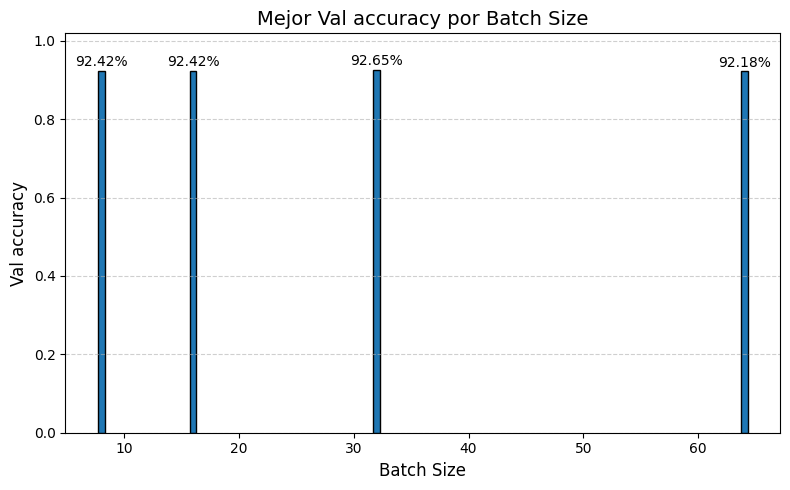

In [ ]:
plot_best_batch_results(resultados, metric='val_accuracy')

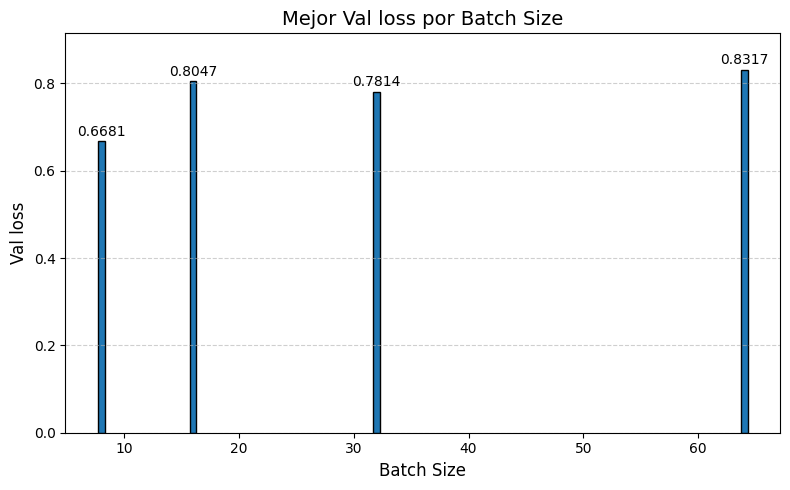

In [ ]:
plot_best_batch_results(resultados, metric='val_loss')

In [ ]:
def plot_training_validation_evolution(resultados, metric='accuracy', figsize=(14, 7)):
    """
    Grafica la evolución del entrenamiento y validación para diferentes batch sizes.

    Parámetros
    ----------
    resultados : list of dict
        Cada dict debe contener:
          - 'batch_size': int
          - 'history': objeto History de Keras (con atributo .history[metric])
    metric : str, opcional
        Nombre base de la métrica (por defecto 'accuracy').
        Se graficará tanto la métrica como 'val_' + metric.
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto) en pulgadas.

    Ejemplo
    -------
    plot_training_validation_evolution(resultados, metric='accuracy')
    """
    # Crear figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Colores para diferentes batch sizes
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Métricas a graficar
    train_metric = metric
    val_metric = f'val_{metric}'

    # Valores máximos y mínimos para cada métrica
    max_train = float('-inf')
    max_val = float('-inf')
    min_train = float('inf')
    min_val = float('inf')

    # Graficar la evolución para cada batch size
    for i, resultado in enumerate(resultados):
        batch_size = resultado['batch_size']
        history = resultado['history'].history

        # Obtener los valores de las métricas
        train_values = history[train_metric]
        val_values = history[val_metric]
        epochs = range(1, len(train_values) + 1)

        # Actualizar máximos
        max_train = max(max_train, max(train_values))
        max_val = max(max_val, max(val_values))

        # Actualizar mínimos
        min_train = min(min(train_values), min_train)
        min_val = min(min(val_values), min_val)

        # Graficar líneas en ambos subplots
        ax1.plot(epochs, train_values, marker='o', linestyle='-', linewidth=2,
                 label=f'Batch: {batch_size}', color=colors[i % len(colors)])

        ax2.plot(epochs, val_values, marker='o', linestyle='-', linewidth=2,
                 label=f'Batch: {batch_size}', color=colors[i % len(colors)])

    # Configurar el primer subplot (entrenamiento)
    ax1.set_title(f'Evolución de {train_metric.replace("_", " ").capitalize()} (Entrenamiento)', fontsize=12)
    ax1.set_xlabel('Épocas', fontsize=10)
    ax1.set_ylabel(train_metric.replace('_', ' ').capitalize(), fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Calcular límites adecuados para el eje Y (evitando multiplicar por 4 si el mínimo es negativo)
    y_min_train = min_train  if min_train > 0 else min_train
    ax1.set_ylim(y_min_train, max_train*1.01 )
    ax1.legend(loc='lower right', fontsize=9)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Configurar el segundo subplot (validación)
    ax2.set_title(f'Evolución de {val_metric.replace("_", " ").capitalize()} (Validación)', fontsize=12)
    ax2.set_xlabel('Épocas', fontsize=10)
    ax2.set_ylabel(val_metric.replace('_', ' ').capitalize(), fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Calcular límites adecuados para el eje Y de validación
    y_min_val = min_val  if min_val > 0 else min_val
    ax2.set_ylim(y_min_val, max_val)
    ax2.legend(loc='lower right', fontsize=9)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

    return fig, (ax1, ax2)

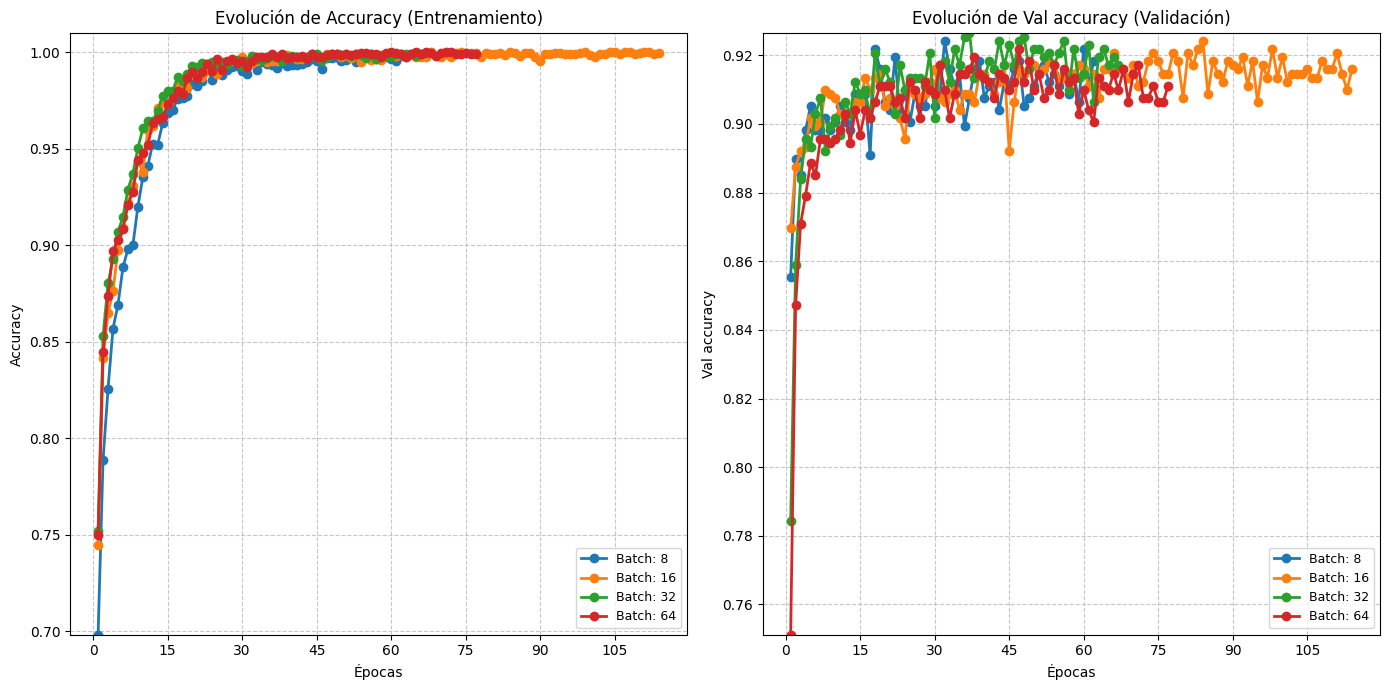

(<Figure size 1400x700 with 2 Axes>,
 (<Axes: title={'center': 'Evolución de Accuracy (Entrenamiento)'}, xlabel='Épocas', ylabel='Accuracy'>,
  <Axes: title={'center': 'Evolución de Val accuracy (Validación)'}, xlabel='Épocas', ylabel='Val accuracy'>))

In [ ]:
plot_training_validation_evolution(resultados, metric='accuracy', figsize=(14, 7))

## Por neuronas

Fijando el tamaño del lote a 32

In [ ]:
# Lista de batch sizes a probar
neuronas = [60,256,1000,5000,10000]

batch_size=32

# Lista donde guardaremos los resultados
resultados = []

for neurona in neuronas:
    # 🔹 Clonar el modelo para empezar cada experimento desde cero
    modelo_clone = build_model_DenseNet(
    img_size=(256, 256),
    channels=3,
    class_count=len(class_names),
    l1=1e-5,
    l2=1e-4,
    dropout_rate=0.6,
    mixup_scale=0.1,
    dense_units=neurona,
    initializer_seed=42
)

    # 🔹 Entrenar con el batch_size actual
    trained_model, batch_usado, history = train(
        modelo_clone,
        train_links, train_labels,
        val_links,   val_labels,
        test_links,  test_labels,
        image_size=(256,256),
        batch_size=batch_size,               # <- aquí usa la variable `bs`
        data_augmentation=True,
        base_dir=None,
        max_epochs=200,
        patience=30,
        min_delta=0.001,
        learning_rate=0.001
    )

    # 🔹 Almacenar resultados
    resultados.append({
        'neurons': neurona,
        'model':     trained_model,
        'history':   history
    })

    print(f'Entrenamiento con  ||||| {neurona} ||||| neuronas, realizado')

# Ahora `resultados` es una lista de dicts con:
#   - neurona probado
#   - model       entrenado (con los mejores pesos guardados)
#   - history     del fit para cada experimento

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6061 - loss: 1.2683
Epoch 1: val_accuracy improved from -inf to 0.77962, saving model to /content/models/bs32_20250506-161052/best_epoch01_valacc0.7796.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 78s 523ms/step - accuracy: 0.6072 - loss: 1.2641 - val_accuracy: 0.7796 - val_loss: 0.6595
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7930 - loss: 0.6588
Epoch 2: val_accuracy improved from 0.77962 to 0.83649, saving model to /content/models/bs32_20250506-161052/best_epoch02_valacc0.8365.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.7933 - loss: 0.6580 - val_accuracy: 0.8365 - val_loss: 0.4959
Epoch 3/200
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8352 - loss: 0.5184
Epoch 3: val_accuracy improved from 0.83649 to 0.86967, saving model to /content/models/bs32_20250506-161052/best_epoch03_valacc0.8697.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8355 - loss: 0.5177 - val_accurac

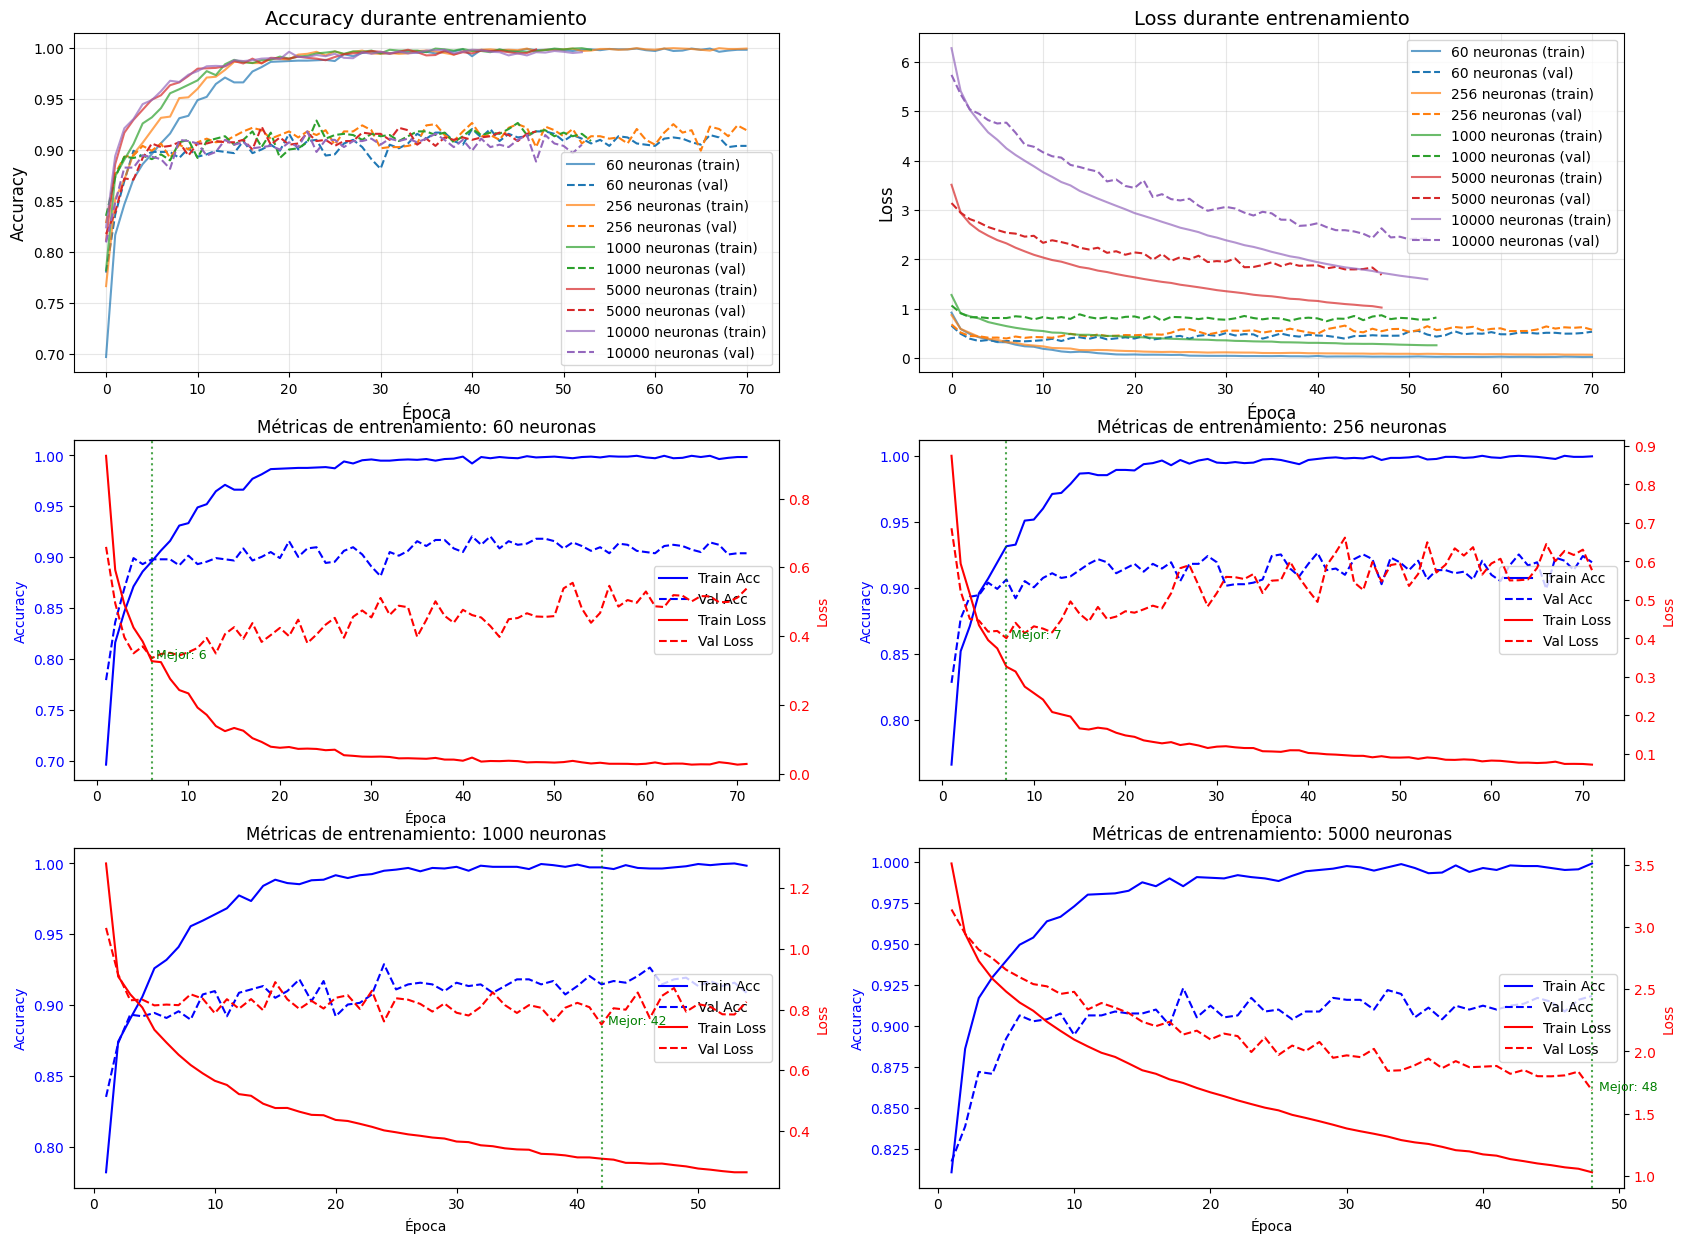

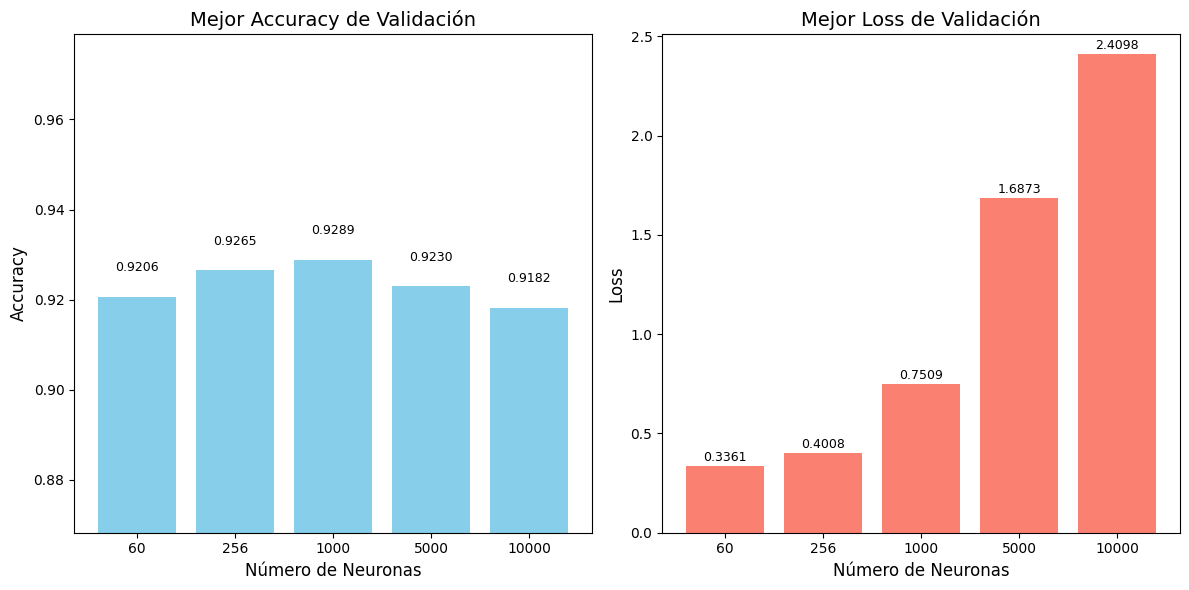

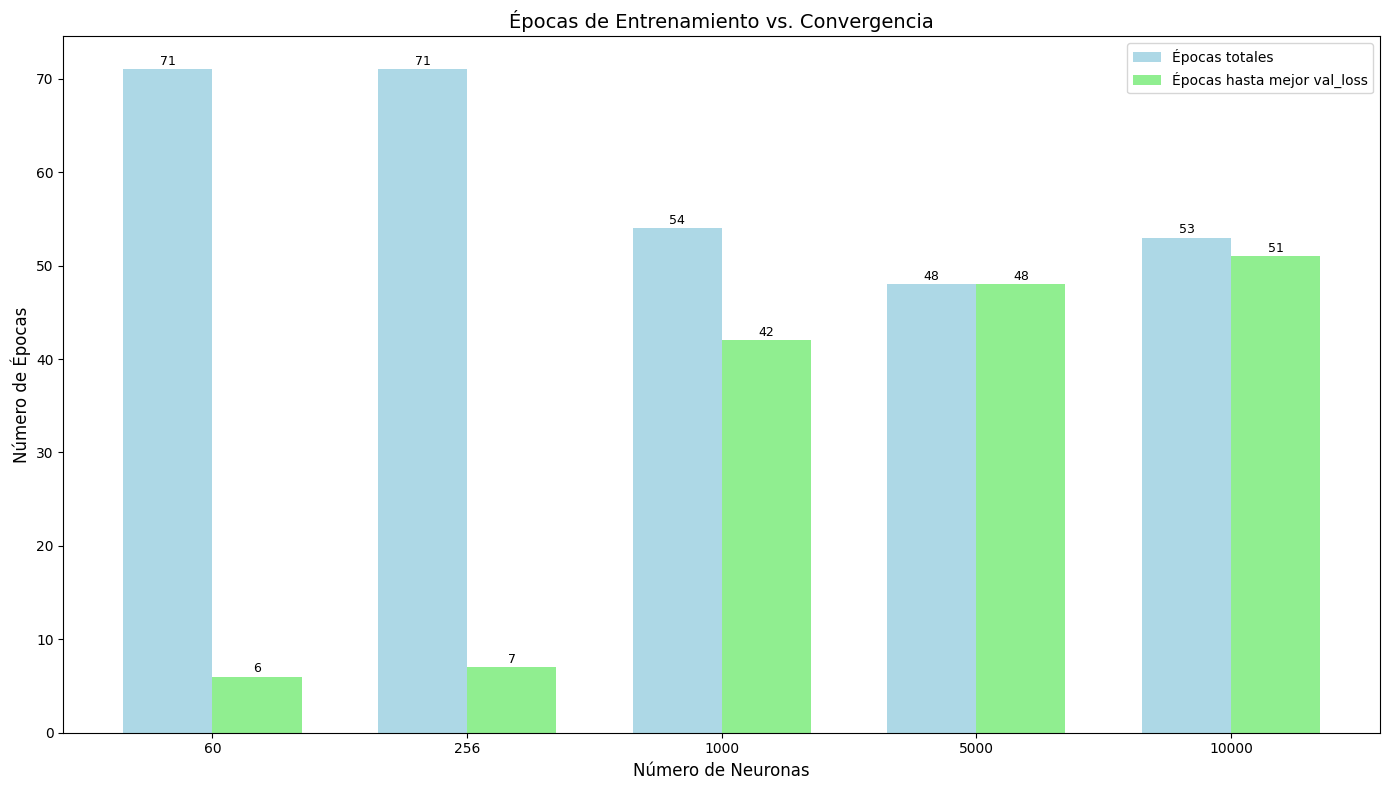

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir colores para la visualización
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Crear una figura grande para todos los gráficos
plt.figure(figsize=(20, 15))

# 1. ACCURACY Y LOSS DURANTE EL ENTRENAMIENTO (UN GRÁFICO POR CADA CONFIGURACIÓN)
for i, resultado in enumerate(resultados):
    neurona = resultado['neurons']
    history = resultado['history']
    color = colors[i % len(colors)]

    # Gráfico de accuracy
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], linestyle='-', color=color, alpha=0.7,
             label=f'{neurona} neuronas (train)')
    plt.plot(history.history['val_accuracy'], linestyle='--', color=color,
             label=f'{neurona} neuronas (val)')

    # Gráfico de loss
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], linestyle='-', color=color, alpha=0.7,
             label=f'{neurona} neuronas (train)')
    plt.plot(history.history['val_loss'], linestyle='--', color=color,
             label=f'{neurona} neuronas (val)')

# Configuración del gráfico de accuracy
plt.subplot(3, 2, 1)
plt.title('Accuracy durante entrenamiento', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)

# Configuración del gráfico de loss
plt.subplot(3, 2, 2)
plt.title('Loss durante entrenamiento', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=10)

# 2. GRÁFICOS INDIVIDUALES POR CONFIGURACIÓN
for i, resultado in enumerate(resultados):
    neurona = resultado['neurons']
    history = resultado['history']

    # Posición en la figura
    posicion = i + 3  # Empieza desde la posición 3 (después de los gráficos de accuracy y loss)
    if posicion <= 6:  # Solo mostramos los primeros 4 resultados individuales
        plt.subplot(3, 2, posicion)

        # Graficar accuracy y loss en el mismo gráfico
        epochs = range(1, len(history.history['accuracy']) + 1)

        ax1 = plt.gca()
        ax2 = ax1.twinx()

        # Accuracy (eje izquierdo)
        line1, = ax1.plot(epochs, history.history['accuracy'], 'b-', label='Train Acc')
        line2, = ax1.plot(epochs, history.history['val_accuracy'], 'b--', label='Val Acc')
        ax1.set_xlabel('Época')
        ax1.set_ylabel('Accuracy', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        # Loss (eje derecho)
        line3, = ax2.plot(epochs, history.history['loss'], 'r-', label='Train Loss')
        line4, = ax2.plot(epochs, history.history['val_loss'], 'r--', label='Val Loss')
        ax2.set_ylabel('Loss', color='r')
        ax2.tick_params(axis='y', labelcolor='r')

        # Título y leyenda
        plt.title(f'Métricas de entrenamiento: {neurona} neuronas', fontsize=12)
        lines = [line1, line2, line3, line4]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='center right')

        # Marcar mejor época (donde val_loss es mínimo)
        best_epoch = np.argmin(history.history['val_loss']) + 1
        min_val_loss = min(history.history['val_loss'])
        ax2.axvline(x=best_epoch, color='green', linestyle=':', alpha=0.7)
        ax2.text(best_epoch + 0.5, min_val_loss, f'Mejor: {best_epoch}',
                fontsize=9, color='green')

# 3. GRÁFICO RESUMEN COMPARATIVO (MEJOR ACCURACY Y LOSS)
plt.figure(figsize=(12, 6))

# Preparar datos para la comparación
neuronas_list = [r['neurons'] for r in resultados]
best_val_acc = [max(r['history'].history['val_accuracy']) for r in resultados]
best_val_loss = [min(r['history'].history['val_loss']) for r in resultados]
last_epochs = [len(r['history'].history['val_accuracy']) for r in resultados]

# Gráfico de barras para accuracy
plt.subplot(1, 2, 1)
bars = plt.bar(range(len(neuronas_list)), best_val_acc, color='skyblue')
plt.xticks(range(len(neuronas_list)), neuronas_list)
plt.title('Mejor Accuracy de Validación', fontsize=14)
plt.xlabel('Número de Neuronas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(min(best_val_acc) - 0.05, max(best_val_acc) + 0.05)

# Añadir valores encima de las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Gráfico de barras para loss
plt.subplot(1, 2, 2)
bars = plt.bar(range(len(neuronas_list)), best_val_loss, color='salmon')
plt.xticks(range(len(neuronas_list)), neuronas_list)
plt.title('Mejor Loss de Validación', fontsize=14)
plt.xlabel('Número de Neuronas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(0, max(best_val_loss) + 0.1)

# Añadir valores encima de las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.figure(figsize=(14, 8))

# 4. GRÁFICO DE CONVERGENCIA Y ÉPOCAS DE ENTRENAMIENTO
x = np.arange(len(neuronas_list))
width = 0.35

# Crear gráfico de barras para épocas de entrenamiento
plt.bar(x - width/2, last_epochs, width, label='Épocas totales', color='lightblue')

# Calcular épocas hasta mejor validación
best_epochs = [np.argmin(r['history'].history['val_loss']) + 1 for r in resultados]
plt.bar(x + width/2, best_epochs, width, label='Épocas hasta mejor val_loss', color='lightgreen')

# Añadir etiquetas y configuración
plt.xlabel('Número de Neuronas', fontsize=12)
plt.ylabel('Número de Épocas', fontsize=12)
plt.title('Épocas de Entrenamiento vs. Convergencia', fontsize=14)
plt.xticks(x, neuronas_list)
plt.legend()

# Añadir valores encima de las barras
for i, v in enumerate(last_epochs):
    plt.text(i - width/2, v + 0.5, str(v), ha='center', fontsize=9)

for i, v in enumerate(best_epochs):
    plt.text(i + width/2, v + 0.5, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Por optimizador

In [ ]:
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop, Adagrad, Adadelta, Nadam

In [ ]:
# Definir los optimizadores a probar
optimizadores = ['adam', 'adamax', 'sgd', 'rmsprop', 'nadam']

# Configuración del modelo fija para este experimento
neuronas = 1000
batch_size = 32

# Lista donde guardaremos los resultados
resultados_optimizadores = []

for opt in optimizadores:
    print(f"\n{'='*50}")
    print(f"Iniciando entrenamiento con optimizador: {opt}")
    print(f"{'='*50}")

    # Clonar el modelo para empezar cada experimento desde cero
    modelo_clone = build_model_DenseNet(
        img_size=(256, 256),
        channels=3,
        class_count=len(class_names),
        l1=1e-5,
        l2=1e-4,
        dropout_rate=0.6,
        mixup_scale=0.1,
        dense_units=neuronas,
        initializer_seed=42
    )

    # Entrenar con el optimizador actual
    trained_model, batch_usado, history = train(
        modelo_clone,
        train_links, train_labels,
        val_links,   val_labels,
        test_links,  test_labels,
        image_size=(256,256),
        batch_size=batch_size,
        data_augmentation=True,
        base_dir=None,
        max_epochs=200,
        patience=30,
        min_delta=0.001,
        learning_rate=0.001,
        optimizer=opt  # Usando el optimizador de esta iteración
    )

    # Almacenar resultados
    resultados_optimizadores.append({
        'optimizer': opt,
        'model': trained_model,
        'history': history
    })

    print(f'Entrenamiento con optimizador ||||| {opt} ||||| realizado')


Iniciando entrenamiento con optimizador: adam
Usando optimizador: adam
Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7235 - loss: 1.5435
Epoch 1: val_accuracy improved from -inf to 0.84360, saving model to /content/models/adam_bs32_20250506-165739/adam_epoch01_valacc0.8436.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 529ms/step - accuracy: 0.7246 - loss: 1.5394 - val_accuracy: 0.8436 - val_loss: 1.0007
Epoch 2/200
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8688 - loss: 0.9235
Epoch 2: val_accuracy improved from 0.84360 to 0.85308, saving model to /content/models/adam_bs32_20250506-165739/adam_epoch02_valacc0.8531.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8690 - loss: 0.9219 - val_accuracy: 0.8531 - val_loss: 0.9148
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8994 - loss: 0.7845
Epoch 3: val_accuracy improved from 0.85308 to 0.86730, saving model to /content/models/adam_bs32_20250506-165739/adam_epoch03_valacc0.8673.keras


# Visualizador de convoluciones

Visualizador de convoluciones y activaciones

Forma de la imagen: (256, 256, 3)
Forma del kernel: (5, 5, 3, 5)
Forma de la salida: (128, 128, 5)


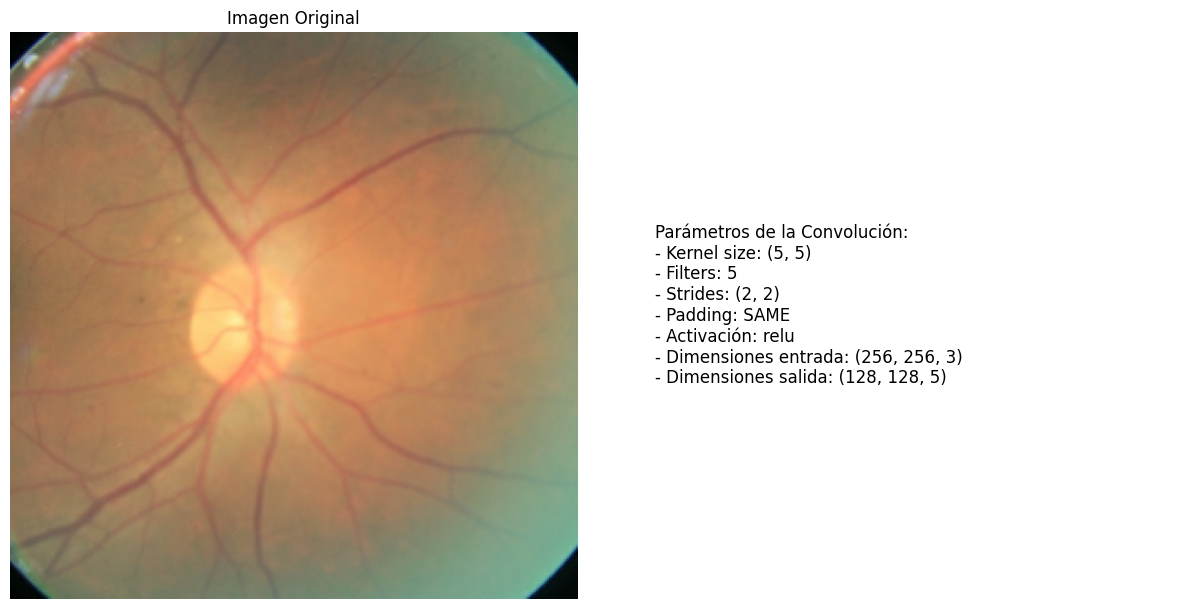

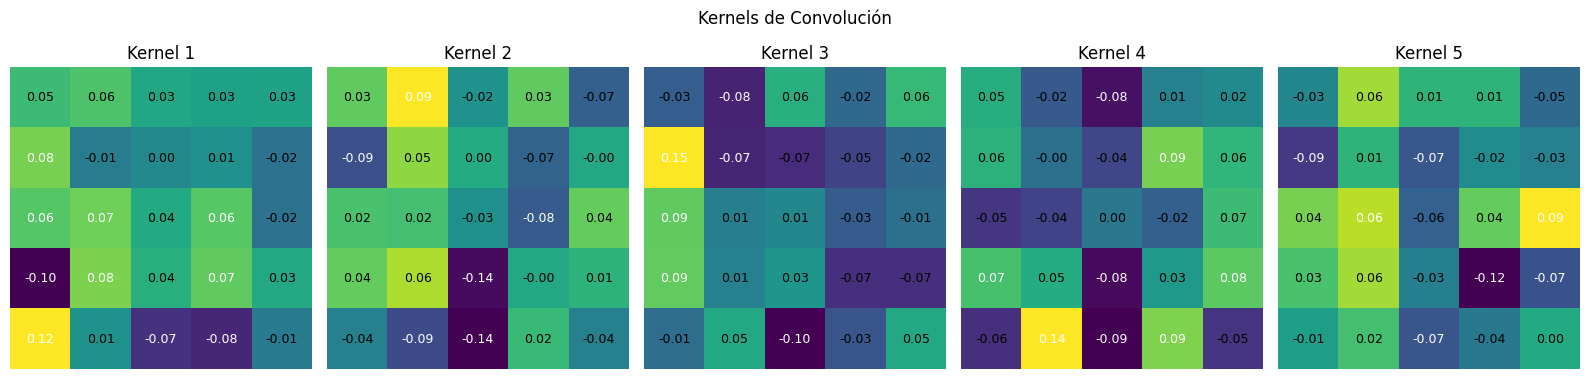

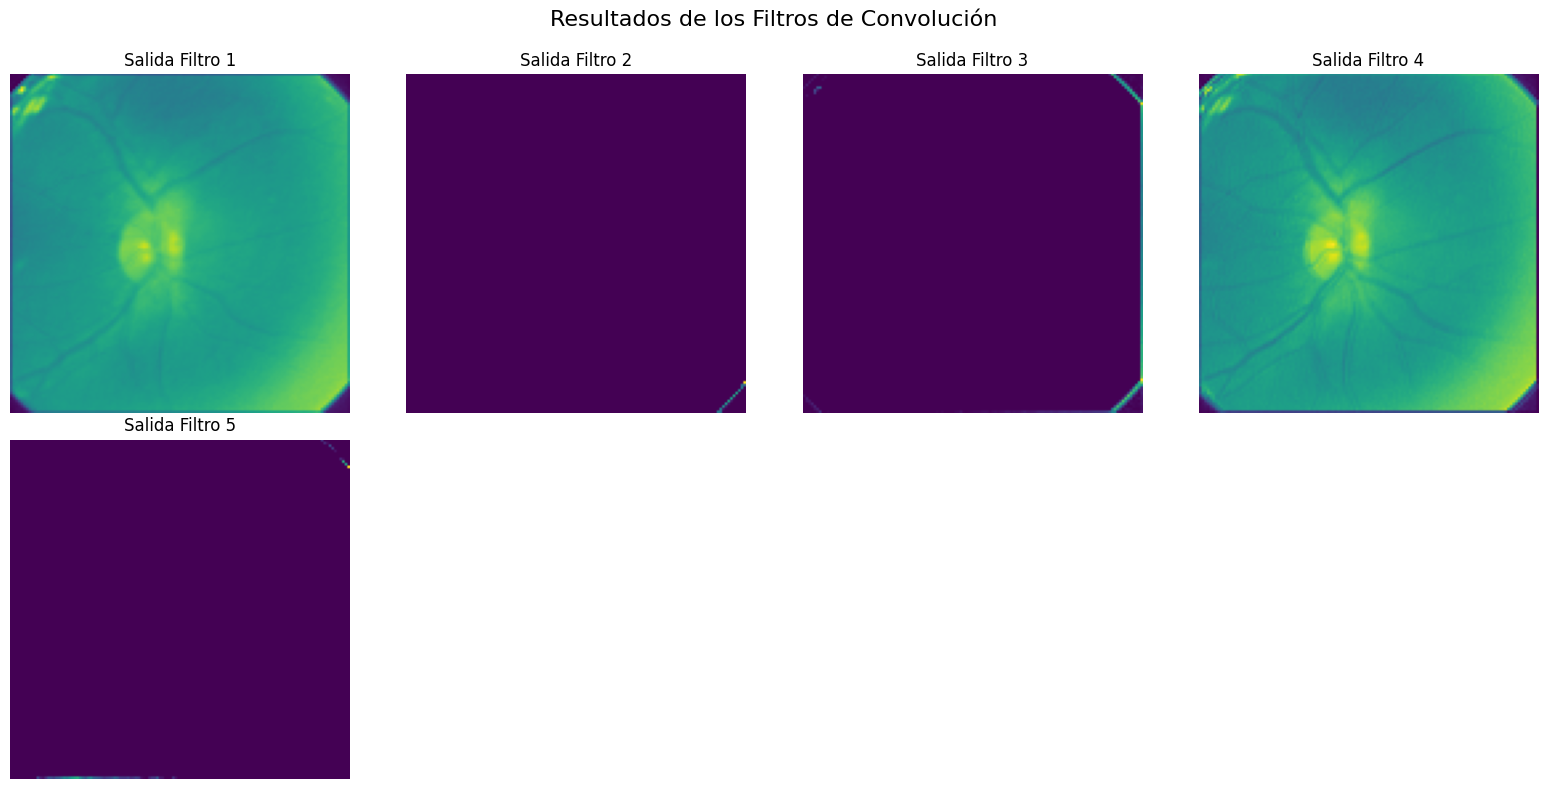

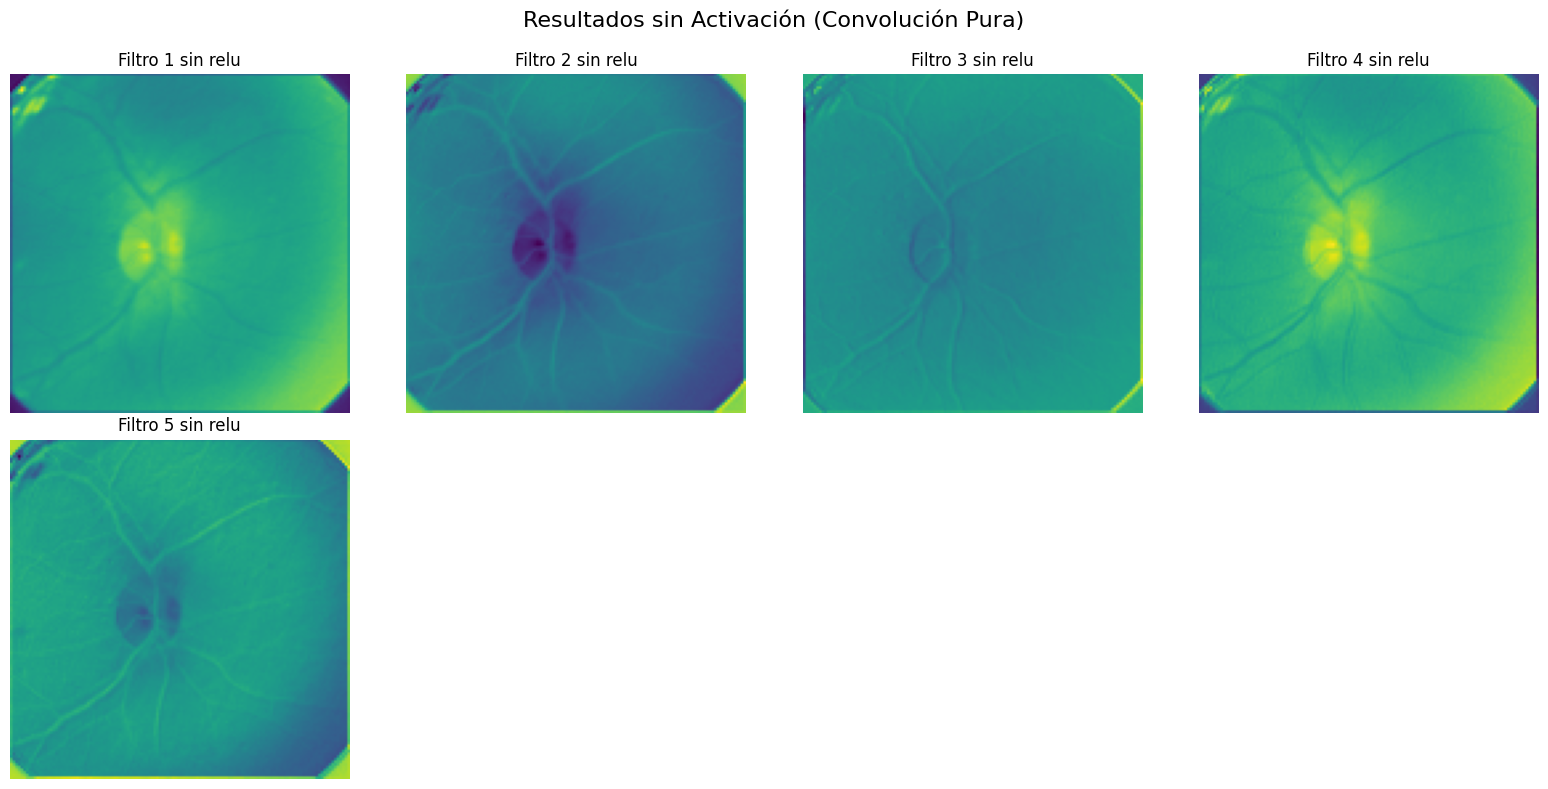

In [47]:
visualize_convolution(
    dataset=train_ds,
    kernel_size=(5, 5),
    filters=5,
    strides=(2, 2),
    activation='relu',
    padding='SAME'
 )